# This code takes in a .csv song_database file output from Tweetybert, figures out the order of syllables, then generates subplots of the transition frequency histogram, normalized transition matrix, and the transition diagram. Finally, it calculates the total transition entropy for each day, then graphs them.

### Import necessary packages. Update:
1) path to .csv file (line 23)
2) Surgery date (line 36)

In [1]:
#import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
import seaborn
from itertools import chain
import ast
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
## need to add stuff to get the .json file that will contain the settings of the spectrograms, time window duration, etc.
sampling_rate = 44100
NFFT = 1024
hop_length = 119
time_window_length = (hop_length / sampling_rate)
print(f"time_window_length: {time_window_length}")

# Load the data, and convert the labels from a string (from csv file) to a numpy array
annotation_data_frame = pd.read_csv('/Users/mirandahulsey-vincent/Desktop/corrected_labels_USA5336_AreaX_Rose_database.csv')
print(annotation_data_frame['labels'])

# Check if there is more than one animal's data
animal_ids = [file_name.split('_')[0] for file_name in annotation_data_frame['file_name']]
unique_animal_ids = set(animal_ids)
num_unique_animal_ids = len(unique_animal_ids)
print(f"animal_ids: {unique_animal_ids}")
if num_unique_animal_ids > 1:
    print("WARNING! YOU HAVE MORE THAN ONE ANIMAL'S DATA IN THIS .CSV FILE!!!")


# Surgery date (for example, '2024-03-10') (YYYY-MM-DD)
surgery_date = pd.to_datetime('2024-04-30')
print(f"Surgery date: {surgery_date}")

## make a folder where the code will save the output graphs
save_figures_TF = True
where_to_save_graphs = '/Users/mirandahulsey-vincent/Desktop'
if save_figures_TF == True:
    output_folder_name = f'{animal_ids[0]}_output_graphs'
    # Ensure the folder exists
    os.makedirs(output_folder_name, exist_ok=True)
    output_folder_path = f'/Users/mirandahulsey-vincent/Desktop'
    print(output_folder_path)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
time_window_length: 0.0026984126984126986
0      [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...
1      [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...
2      [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...
3      [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...
4      [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...
                             ...                        
241    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
242    [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...
24

### Organize into a dataframe

In [2]:
# current columns in the .csv file: song_id,group_id,file_name,date_time,labels,syllable_labels,file_id,spectrogram
# Convert the 'date_time' column to datetime format
annotation_data_frame['date_time'] = pd.to_datetime(annotation_data_frame['date_time'], errors='coerce')
# Verify the conversion by checking the type again
recording_timestamps = annotation_data_frame['date_time']
# Extract only the date
recording_dates = recording_timestamps.dt.date
recording_times = recording_timestamps.dt.time

time_bin_syllable_labels = np.array(annotation_data_frame['labels'])
# Convert each element from a string to a list or array
converted_labels = [np.array(ast.literal_eval(label)) for label in time_bin_syllable_labels]


##FIGURE OUT HOW TO CALCULATE PHRASE DURATIONS USING FIRST LABEL
sample_labels = converted_labels[0]
print(type(sample_labels))  # Should print <class 'numpy.ndarray'>

label_diff = np.diff(sample_labels)
# Find the indices where the label changes (where the difference is non-zero)
phrase_transition_indices = np.where(label_diff != 0)[0]  # Add 1 to adjust for the diff being one element shorter

# Find the last index of labels
last_index_of_labels = len(sample_labels) - 1  # Subtract 1 because Python indexing begins at 0
print(f"Last index of labels: {last_index_of_labels}")

# Define end of phrase indices
end_of_phrase_indices = np.concatenate((phrase_transition_indices, [last_index_of_labels]))
print(f"End of phrase indices: {end_of_phrase_indices}")

# Define start of phrase indices
start_of_phrase_indices = end_of_phrase_indices[0:-1]  # Exclude the last element
first_index_of_labels = 0
start_of_phrase_indices = np.concatenate(([first_index_of_labels], start_of_phrase_indices))
print(f"Start of phrase indices: {start_of_phrase_indices}")

# Determine phrase identities
phrase_identities = sample_labels[end_of_phrase_indices]
print(f"Phrase identities: {phrase_identities}")

<class 'numpy.ndarray'>
Last index of labels: 3220
End of phrase indices: [ 281  379  904  943 1084 1121 1389 1425 1920 2020 2565 2606 2869 3220]
Start of phrase indices: [   0  281  379  904  943 1084 1121 1389 1425 1920 2020 2565 2606 2869]
Phrase identities: [10 12 17 18  4 11  8 21  9 12 17 18  4  6]


### Find the Phrase identities and durations for each row, and add to the annotation_data_frame

In [3]:
# Function to calculate phrase durations in time bins and in seconds for a given set of labels
def calculate_phrase_durations_and_identities(labels, time_window_length):
    # Convert the labels from string to numpy array
    sample_labels = np.array(ast.literal_eval(labels))
    
    # Calculate the differences between consecutive labels
    label_diff = np.diff(sample_labels)
    
    # Find the indices where the label changes (where the difference is non-zero)
    phrase_transition_indices = np.where(label_diff != 0)[0]
    
    # Find the last index of labels
    last_index_of_labels = len(sample_labels) - 1
    
    # Define end of phrase indices
    end_of_phrase_indices = np.concatenate((phrase_transition_indices, [last_index_of_labels]))
    
    # Define start of phrase indices
    start_of_phrase_indices = end_of_phrase_indices[0:-1]
    first_index_of_labels = 0
    start_of_phrase_indices = np.concatenate(([first_index_of_labels], start_of_phrase_indices))
    
    # Determine phrase identities
    phrase_identities = sample_labels[end_of_phrase_indices]
    
    # Calculate phrase durations in terms of time bins
    num_time_windows_of_phrases = end_of_phrase_indices - start_of_phrase_indices
    
    # Convert durations to seconds
    phrase_durations_in_seconds = num_time_windows_of_phrases * time_window_length
    
    return num_time_windows_of_phrases, phrase_durations_in_seconds, phrase_identities

# Lists to store phrase durations and identities for each recording
all_phrase_durations_in_time_bins = []
all_phrase_durations_in_seconds = []
all_phrase_identities = []

# Iterate through each recording in the DataFrame
for index, row in annotation_data_frame.iterrows():
    labels = row['labels']
    num_time_bins, phrase_durations_in_seconds, phrase_identities = calculate_phrase_durations_and_identities(labels, time_window_length)
    
    # Append the results to the lists
    all_phrase_durations_in_time_bins.append(num_time_bins)
    all_phrase_durations_in_seconds.append(phrase_durations_in_seconds)
    all_phrase_identities.append(phrase_identities)

# Add the results as new columns to the DataFrame
annotation_data_frame['phrase_durations_in_time_bins'] = all_phrase_durations_in_time_bins
annotation_data_frame['phrase_durations_in_seconds'] = all_phrase_durations_in_seconds
annotation_data_frame['phrase_identities'] = all_phrase_identities

# Print the updated DataFrame to verify
#print(annotation_data_frame[['song_id', 'phrase_durations_in_time_bins', 'phrase_durations_in_seconds', 'phrase_identities']])
print(annotation_data_frame.head(3))

        song_id     group_id  \
0  45227.423294  after_trial   
1  45220.445149  after_trial   
2  45223.396223  after_trial   

                                           file_name           date_time  \
0  USA5336_45227.42329401_10_28_11_45_29_segment_... 2023-10-28 11:45:29   
1  USA5336_45220.44514918_10_21_12_21_54_segment_... 2023-10-21 12:21:54   
2  USA5336_45223.39622302_10_24_11_0_22_segment_0... 2023-10-24 11:00:22   

                                              labels  \
0  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...   
1  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...   
2  [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...   

                                     syllable_labels  file_id  \
0  [-1, -1, -1, -1, -1, 10, 10, 10, 10, 10, -1, -...        0   
1  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...        1   
2  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...        2   

                                         spectrogram  \
0  [[ 0.42130047  0.3037

### Find all the transition and their frequencies in all the songs

In [4]:
import pandas as pd
from collections import Counter

def calculate_unique_transitions(row):
    # Get the list of syllable labels for the row
    phrase_ids = row
    
    # Create a list of transitions between consecutive syllables
    transitions = [(phrase_ids[i], phrase_ids[i+1]) for i in range(len(phrase_ids) - 1)]
    
    # Count the unique transitions and their frequencies
    transition_counts = Counter(transitions)
    
    # Number of unique transitions
    unique_transition_count = len(transition_counts)
    
    return unique_transition_count, dict(transition_counts)

# Apply the function to each row in the phrase_identities column
annotation_data_frame['unique_transitions'] = annotation_data_frame['phrase_identities'].apply(lambda x: calculate_unique_transitions(x))

# Split the result into separate columns
annotation_data_frame['num_unique_transitions'] = annotation_data_frame['unique_transitions'].apply(lambda x: x[0])
annotation_data_frame['transition_frequencies'] = annotation_data_frame['unique_transitions'].apply(lambda x: x[1])

# Drop the intermediate column
annotation_data_frame = annotation_data_frame.drop(columns=['unique_transitions'])

# Display the result
annotation_data_frame[['num_unique_transitions', 'transition_frequencies']].head()

num_unique_transitions                             transition_frequencies
0                      10  {(10, 12): 1, (12, 17): 2, (17, 18): 2, (18, 4...
1                      20  {(4, 23): 1, (23, 25): 2, (25, 22): 2, (22, 0)...
2                      14  {(23, 21): 1, (21, 23): 1, (23, 22): 1, (22, 0...
3                      14  {(19, 20): 2, (20, 19): 2, (19, 18): 1, (18, 4...
4                       7  {(4, 23): 1, (23, 25): 1, (25, 24): 1, (24, 22...

### Step 5: Combine these codes into one function

Analyzing transitions for: 2024-04-27
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-27_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-27_phrase_transitions.png


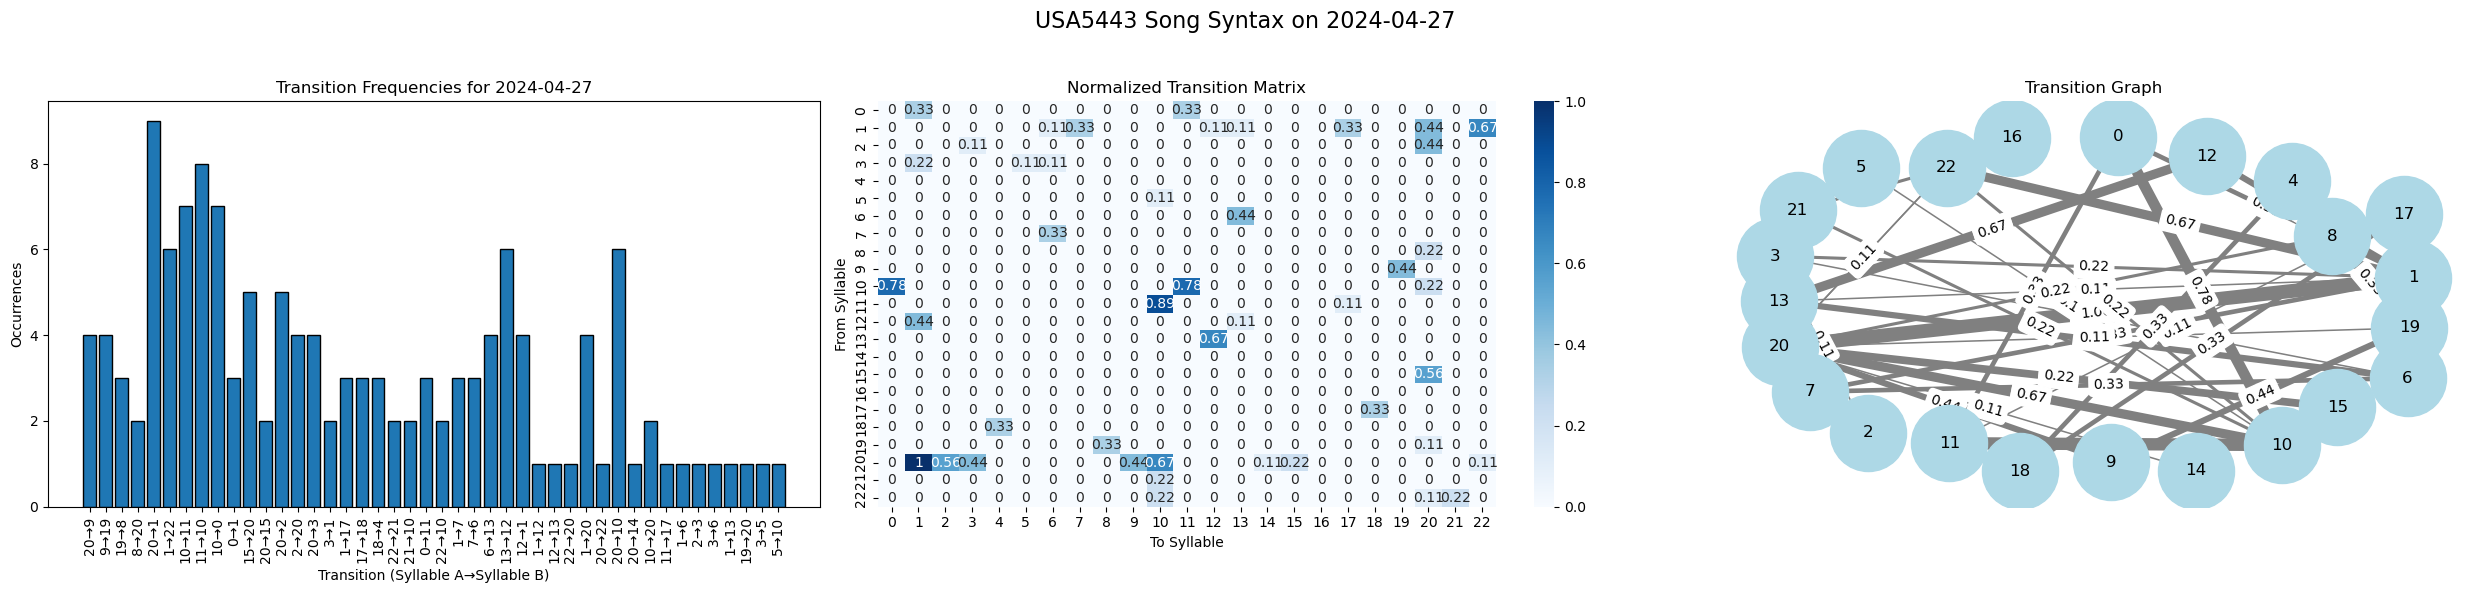

Analyzing transitions for: 2024-05-09
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-09_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-09_phrase_transitions.png


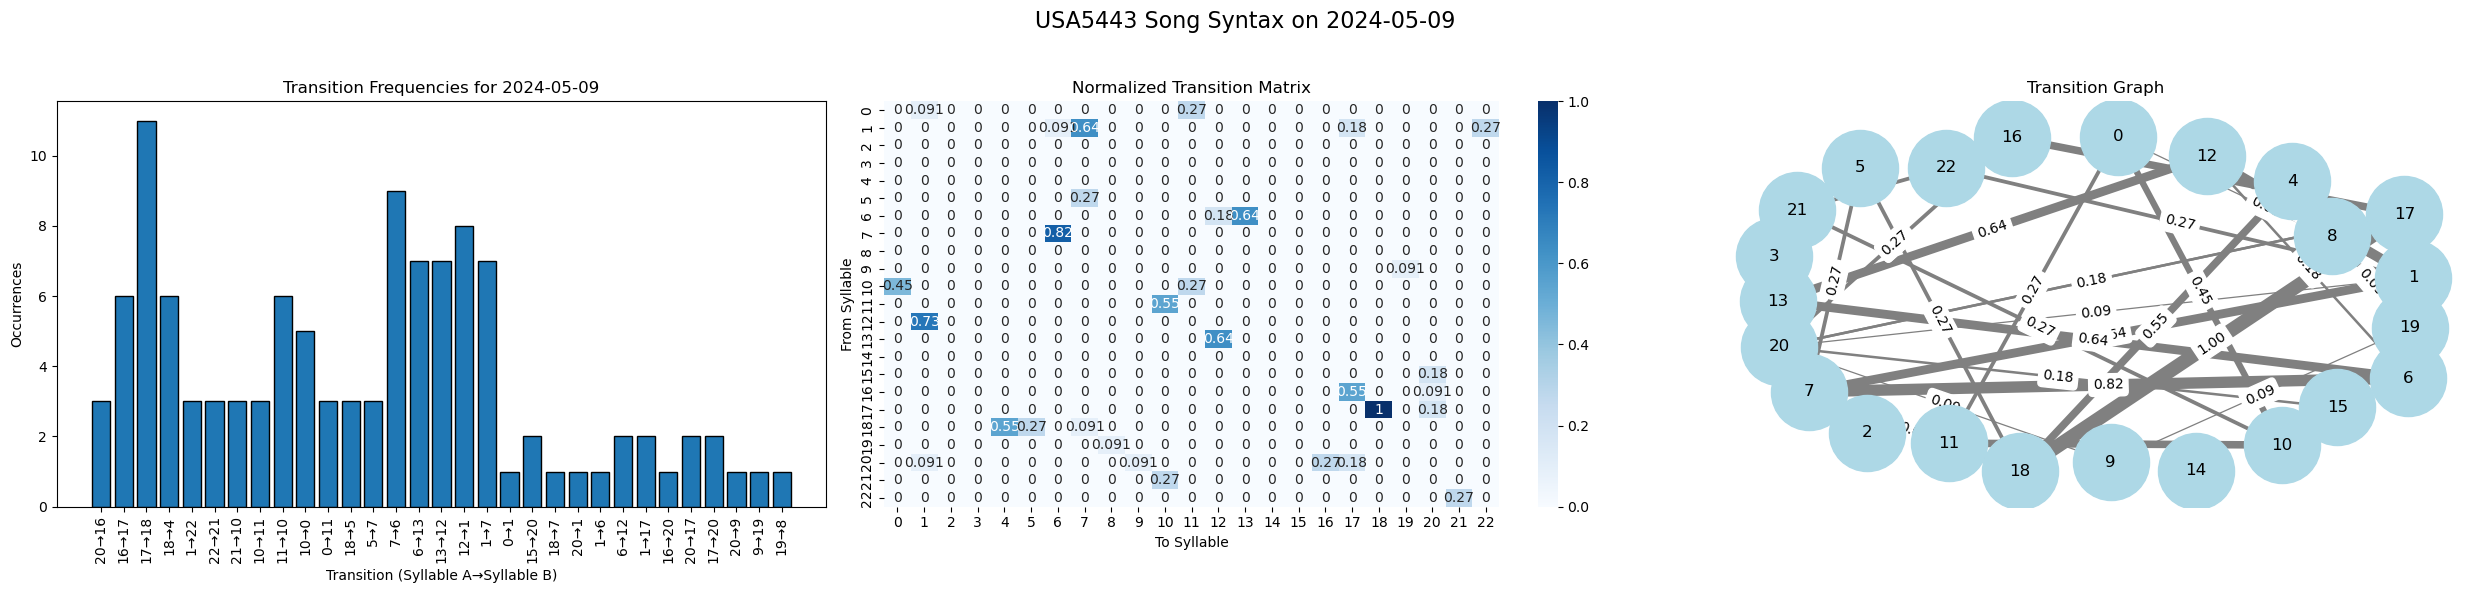

Analyzing transitions for: 2024-05-07
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-07_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-07_phrase_transitions.png


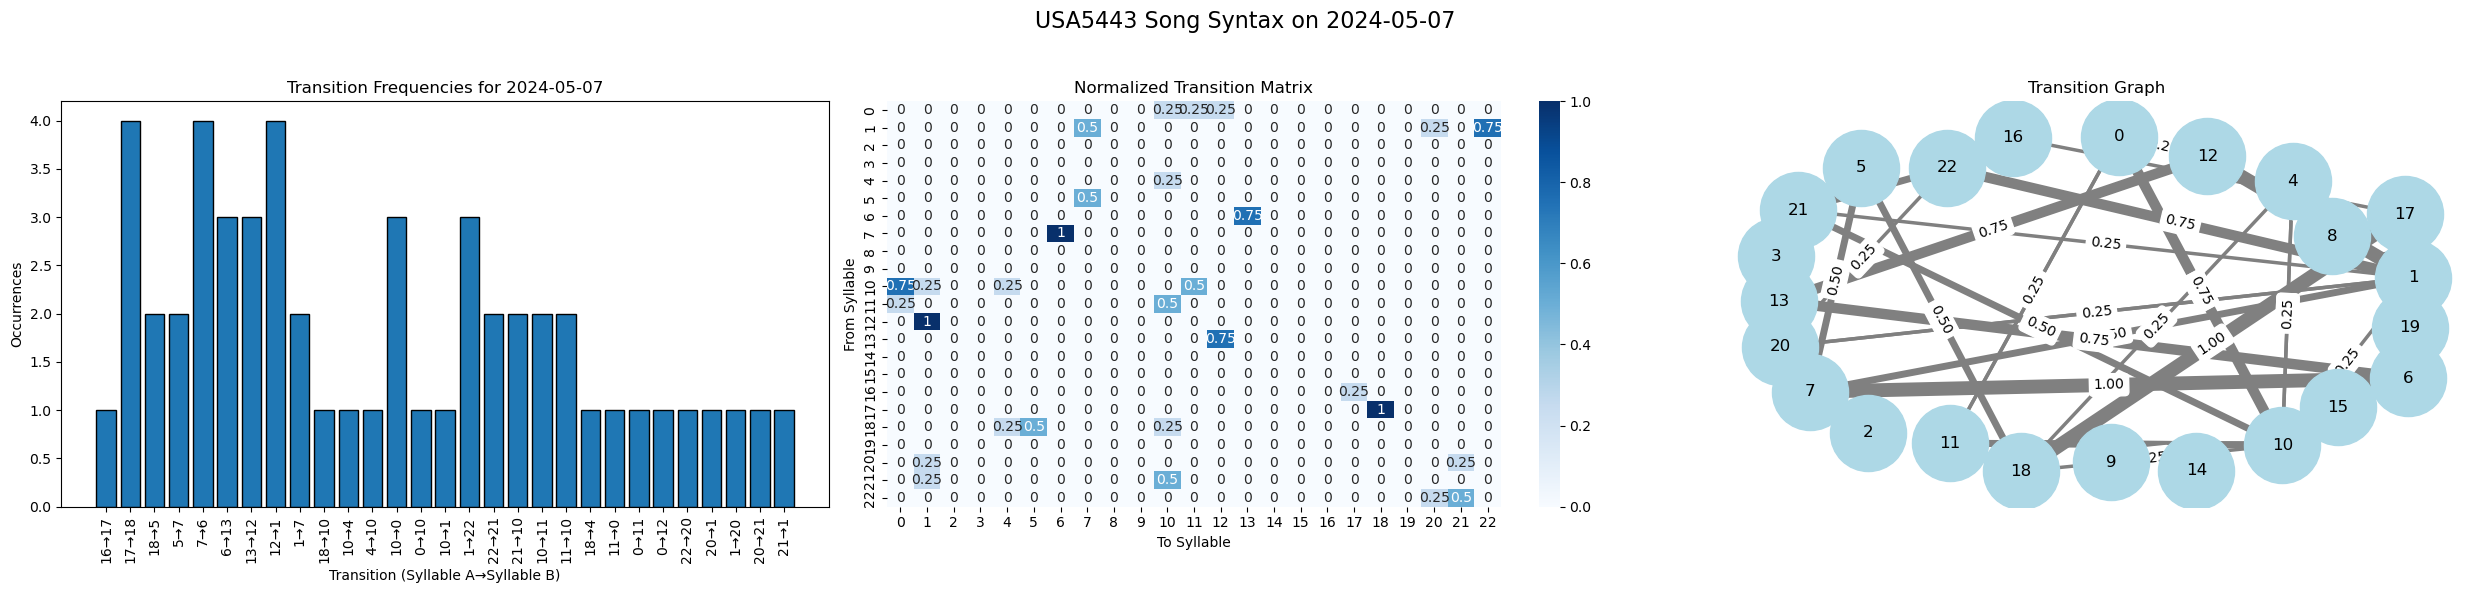

Analyzing transitions for: 2024-04-14
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-14_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-14_phrase_transitions.png


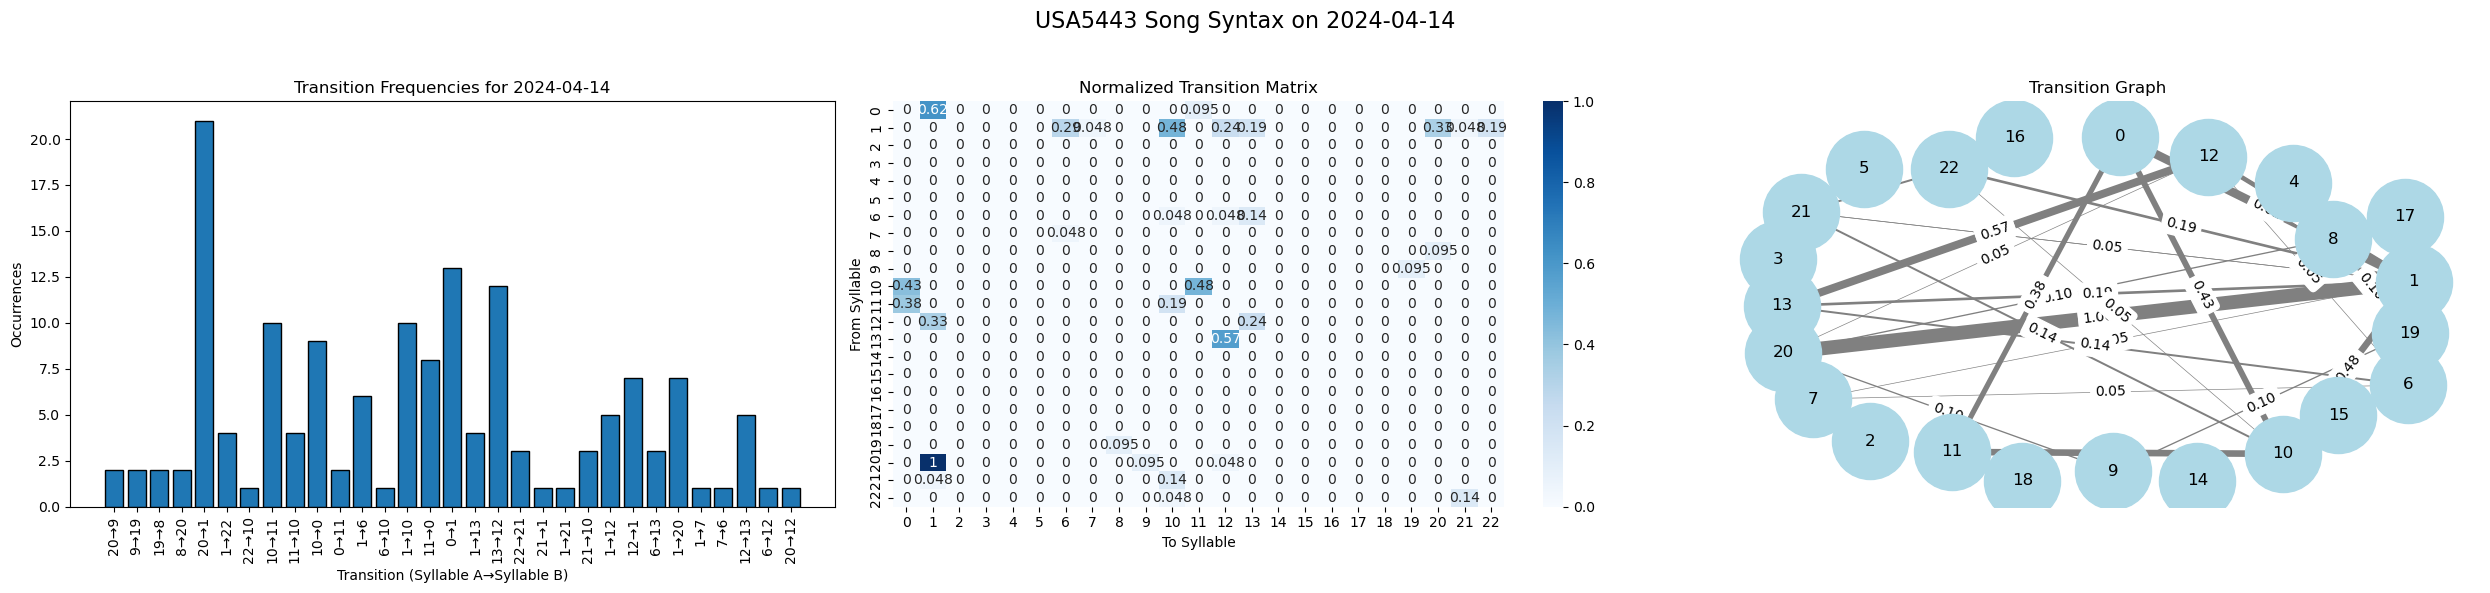

Analyzing transitions for: 2024-05-10
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-10_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-10_phrase_transitions.png


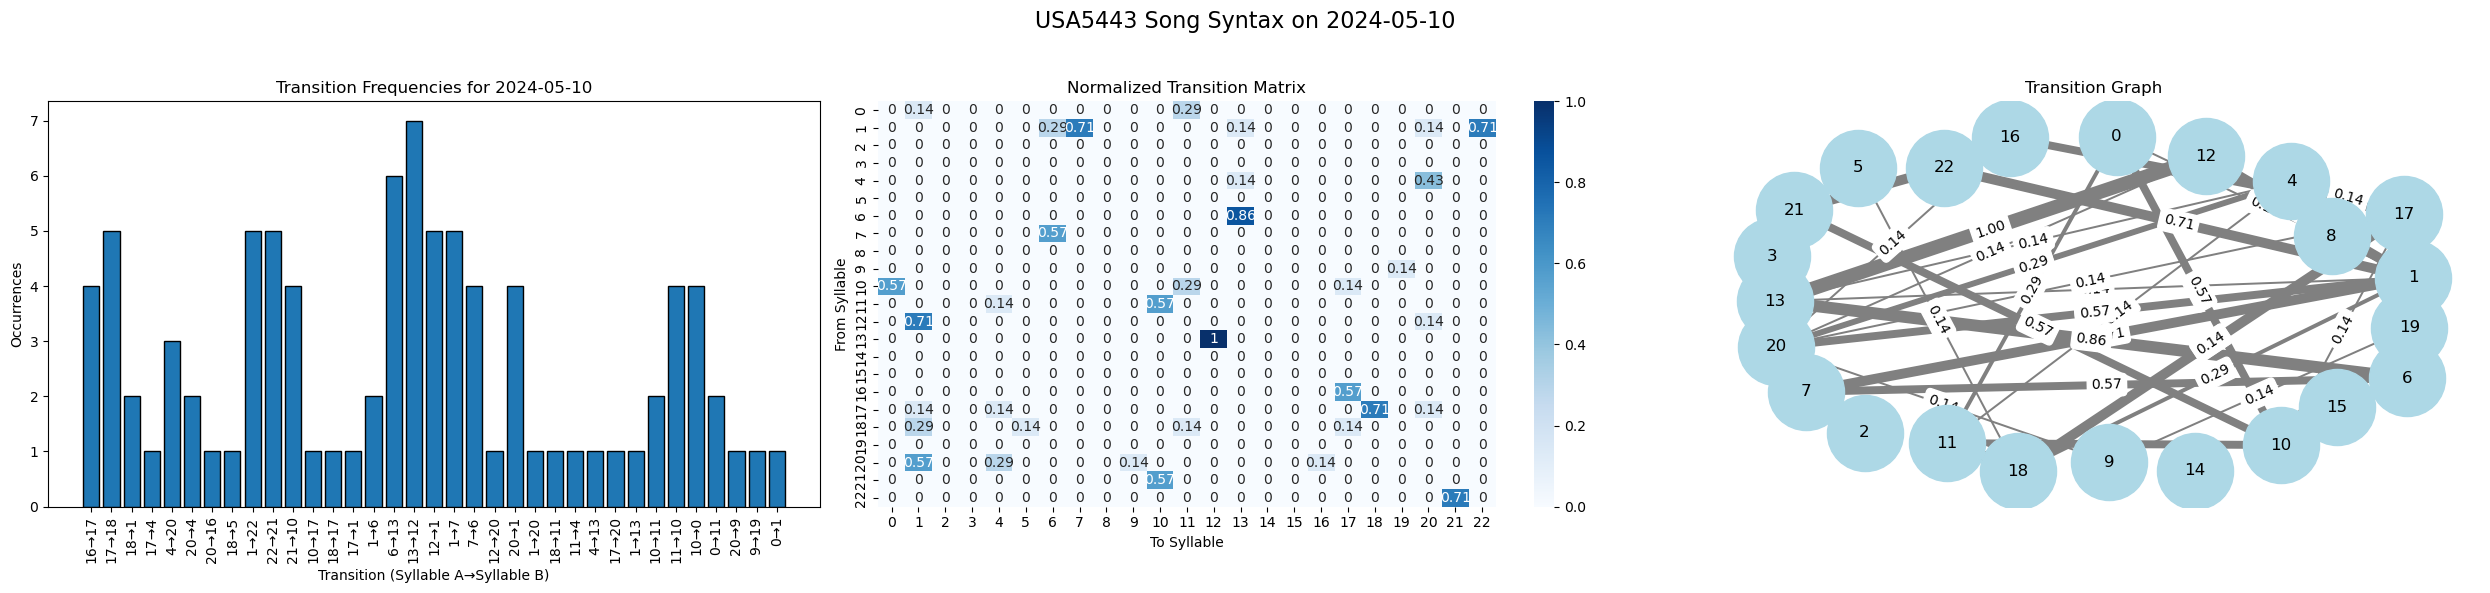

Analyzing transitions for: 2024-04-26
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-26_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-26_phrase_transitions.png


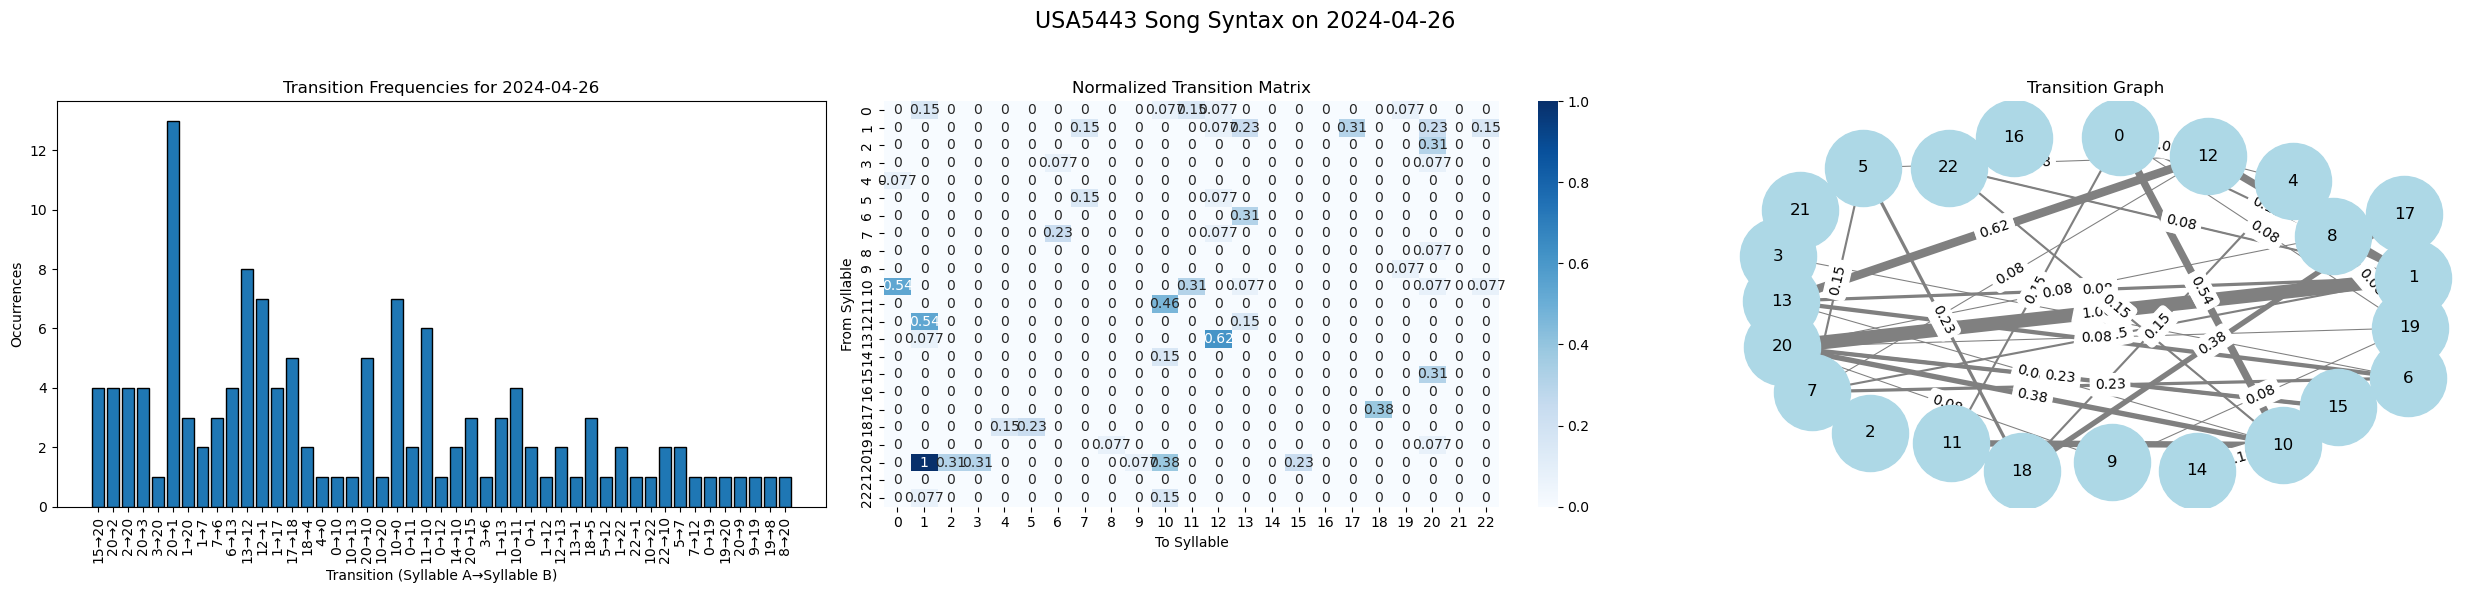

Analyzing transitions for: 2024-04-28
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-28_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-28_phrase_transitions.png


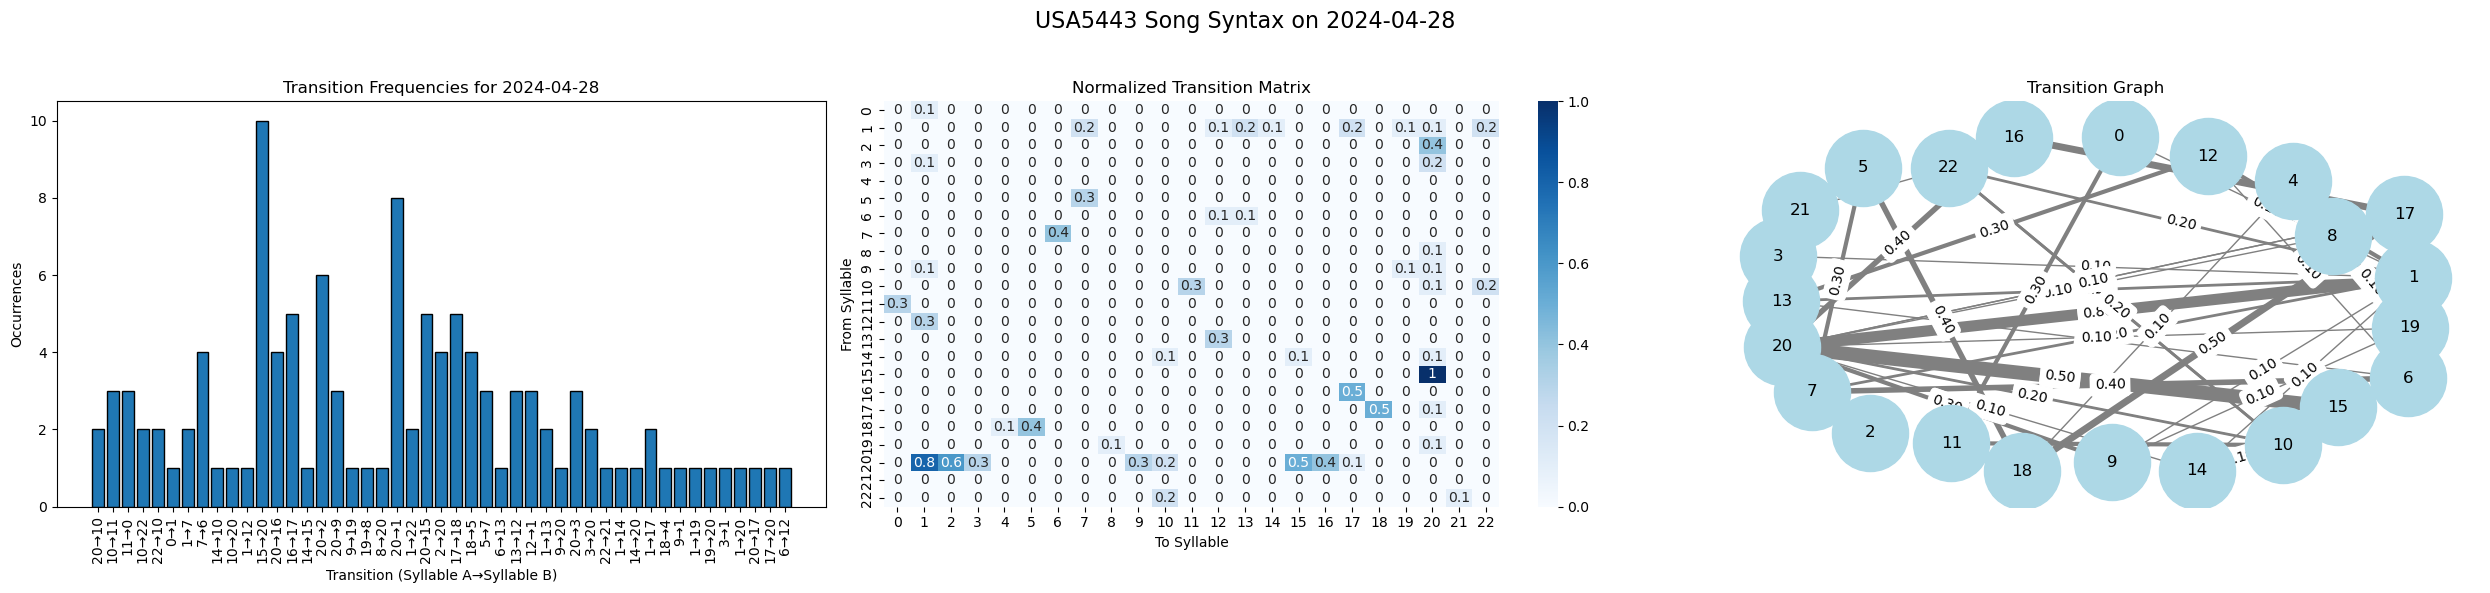

Analyzing transitions for: 2024-04-25
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-25_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-25_phrase_transitions.png


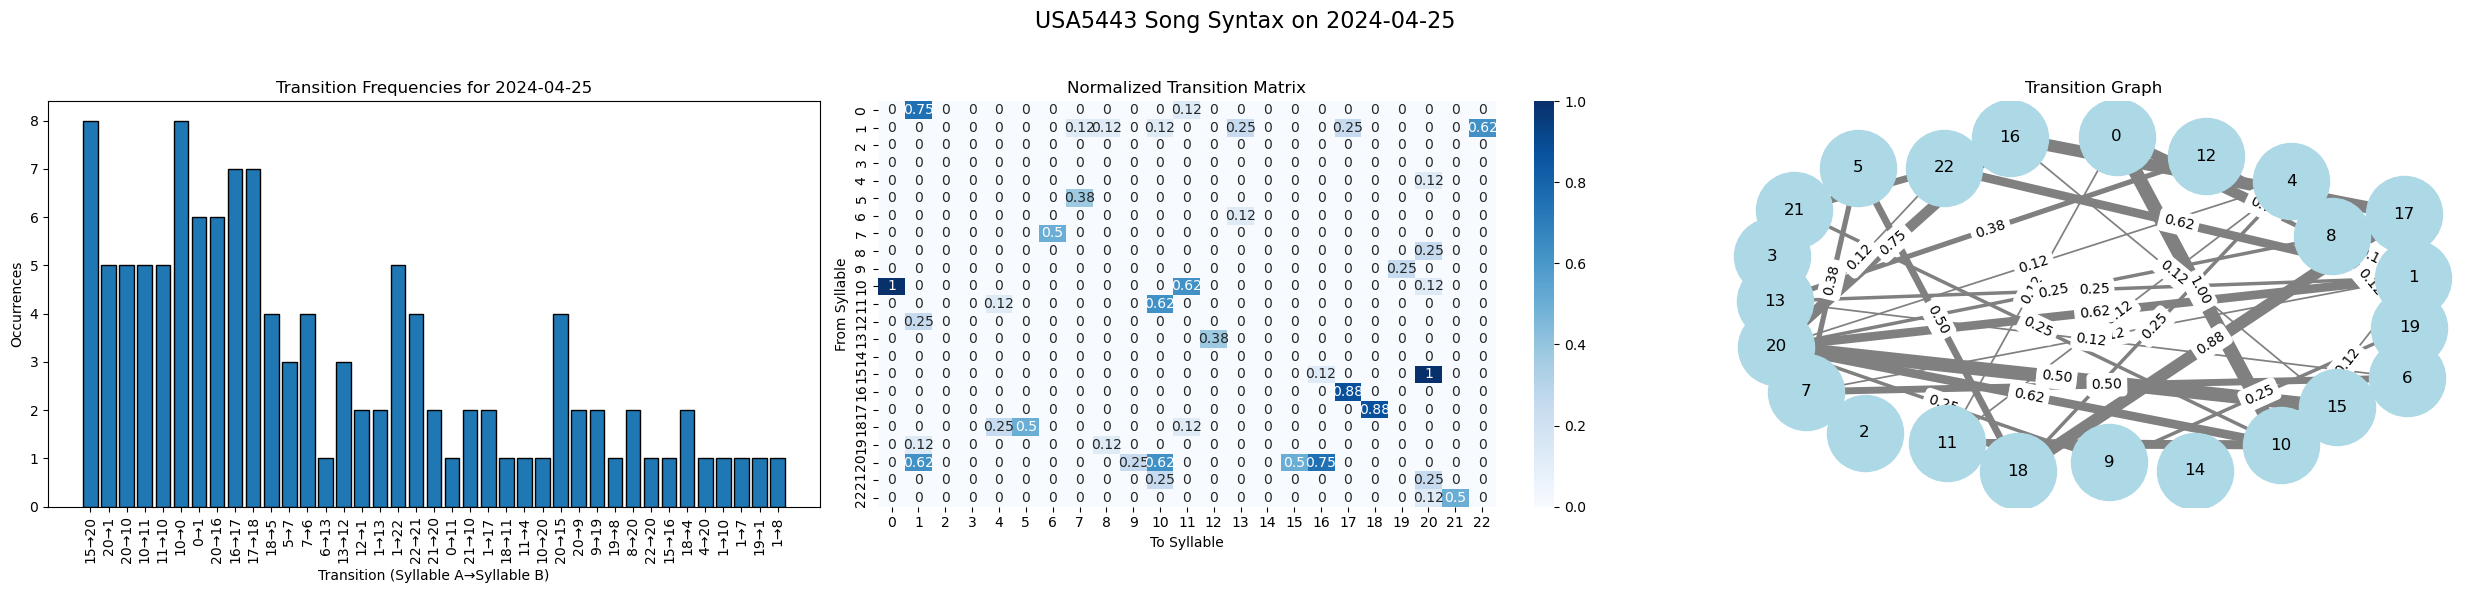

Analyzing transitions for: 2024-04-23
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-23_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-23_phrase_transitions.png


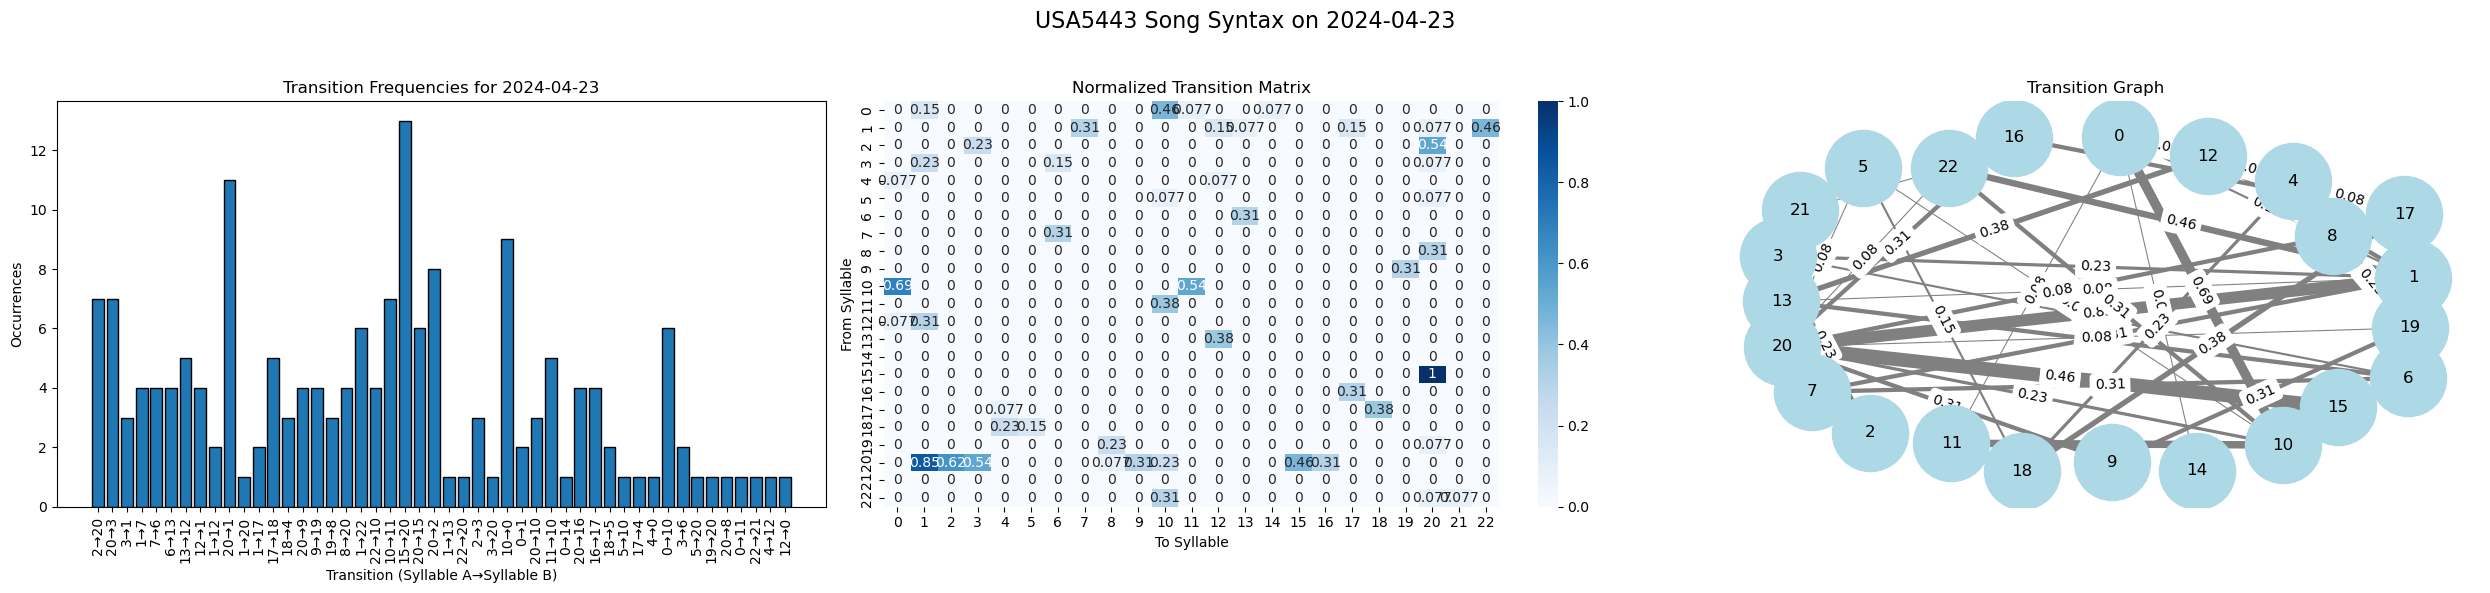

Analyzing transitions for: 2024-04-21
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-21_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-21_phrase_transitions.png


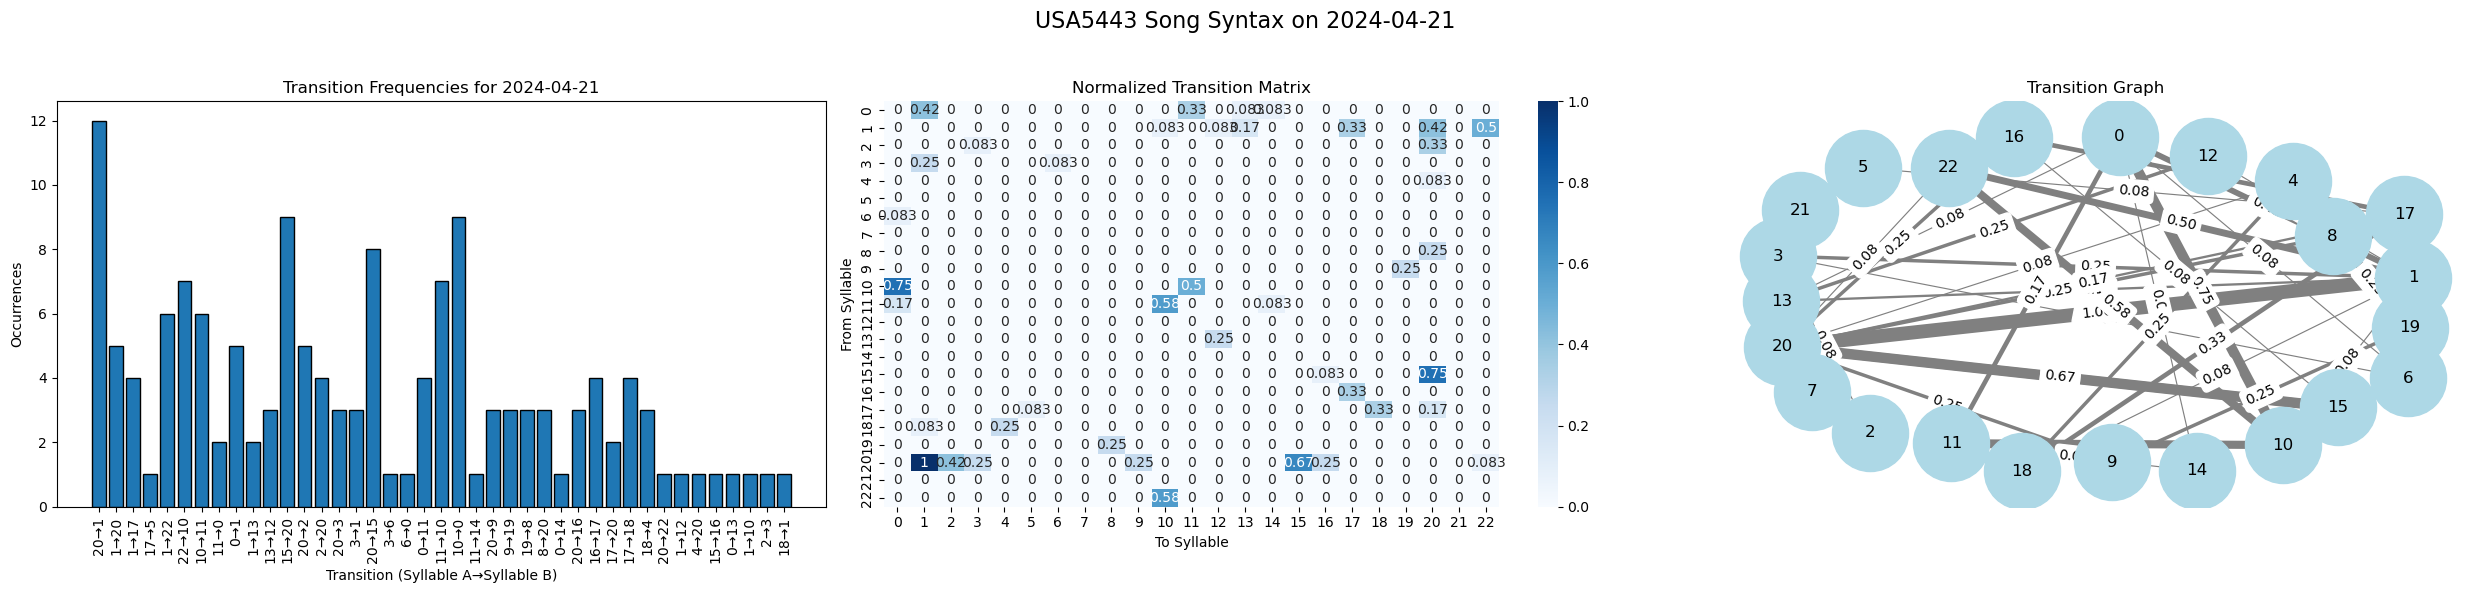

Analyzing transitions for: 2024-04-12
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-12_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-12_phrase_transitions.png


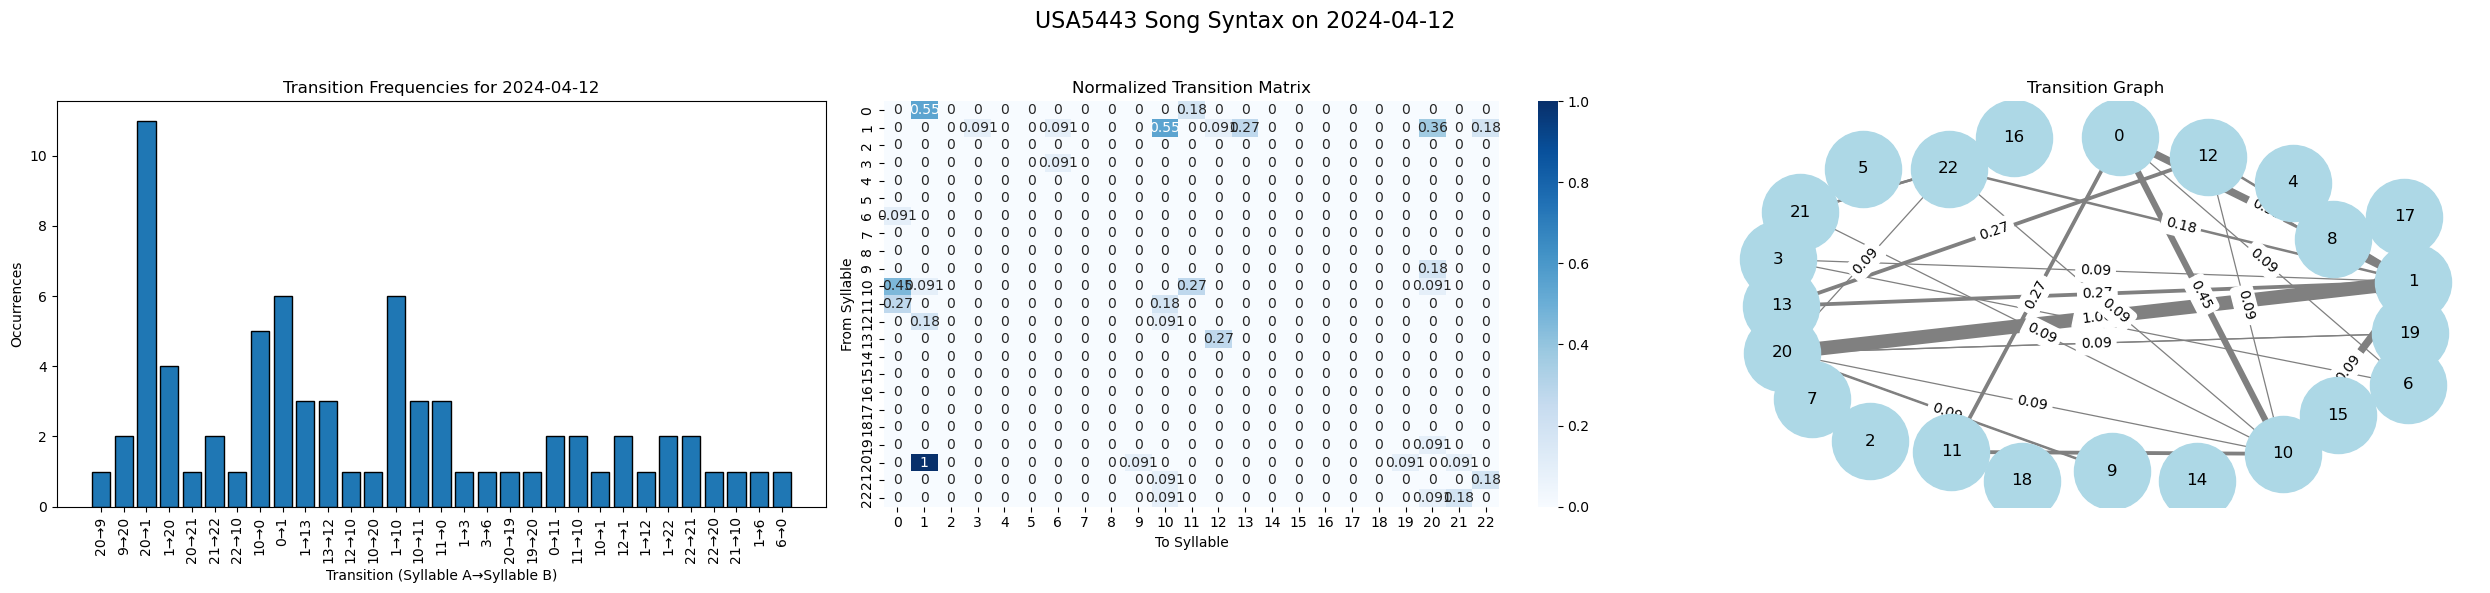

Analyzing transitions for: 2024-04-24
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-24_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-24_phrase_transitions.png


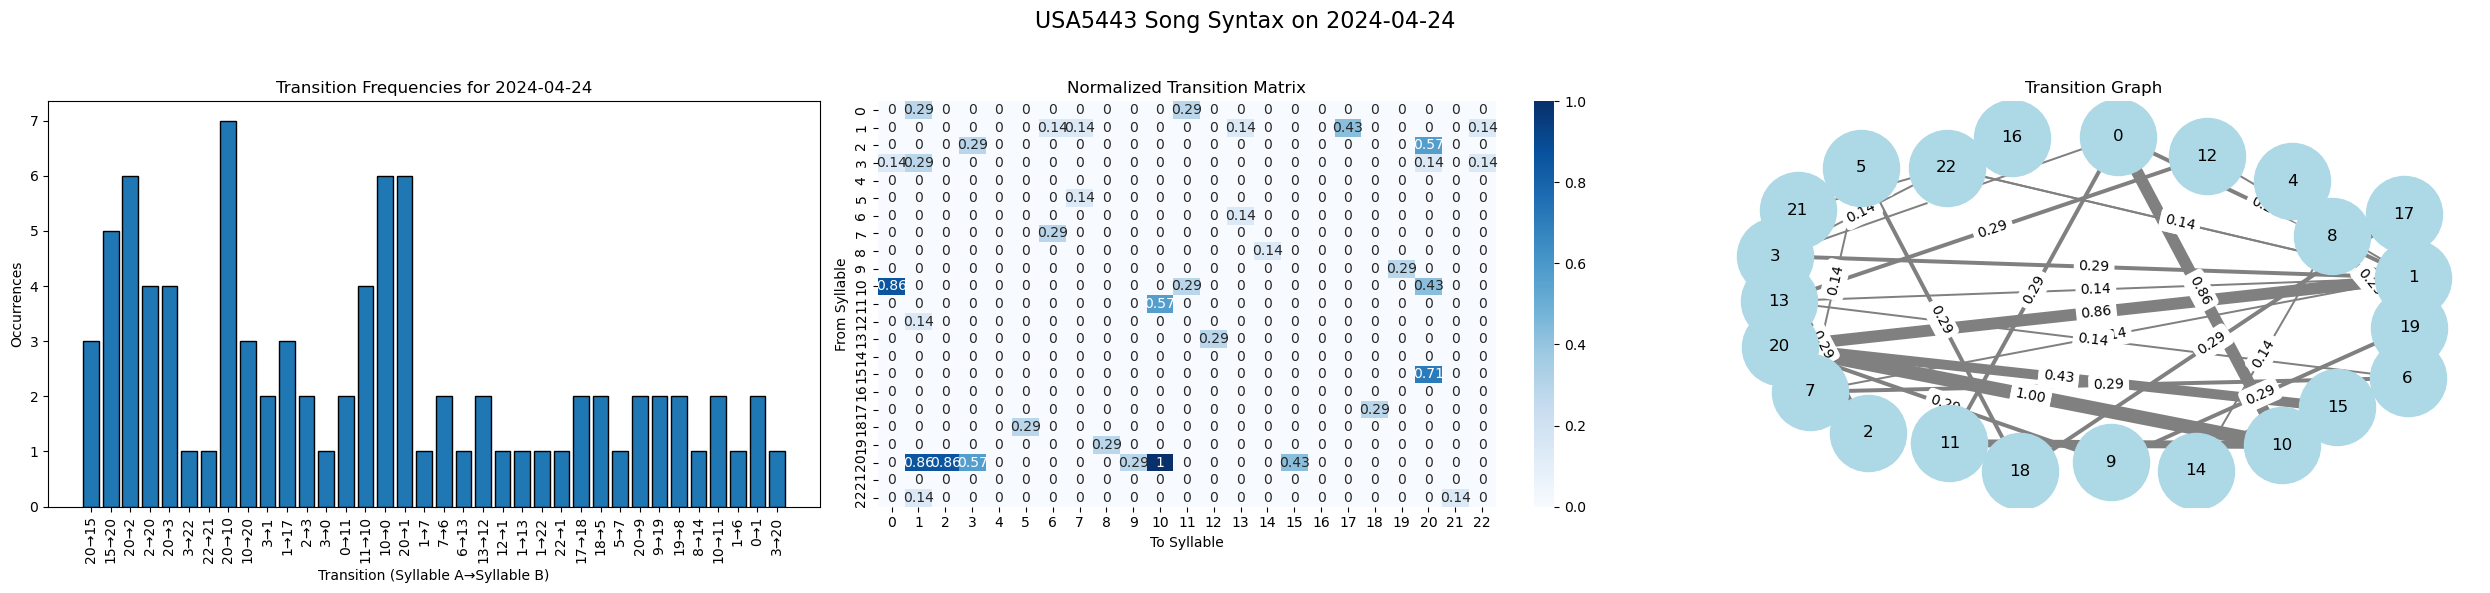

Analyzing transitions for: 2024-04-13
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-13_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-13_phrase_transitions.png


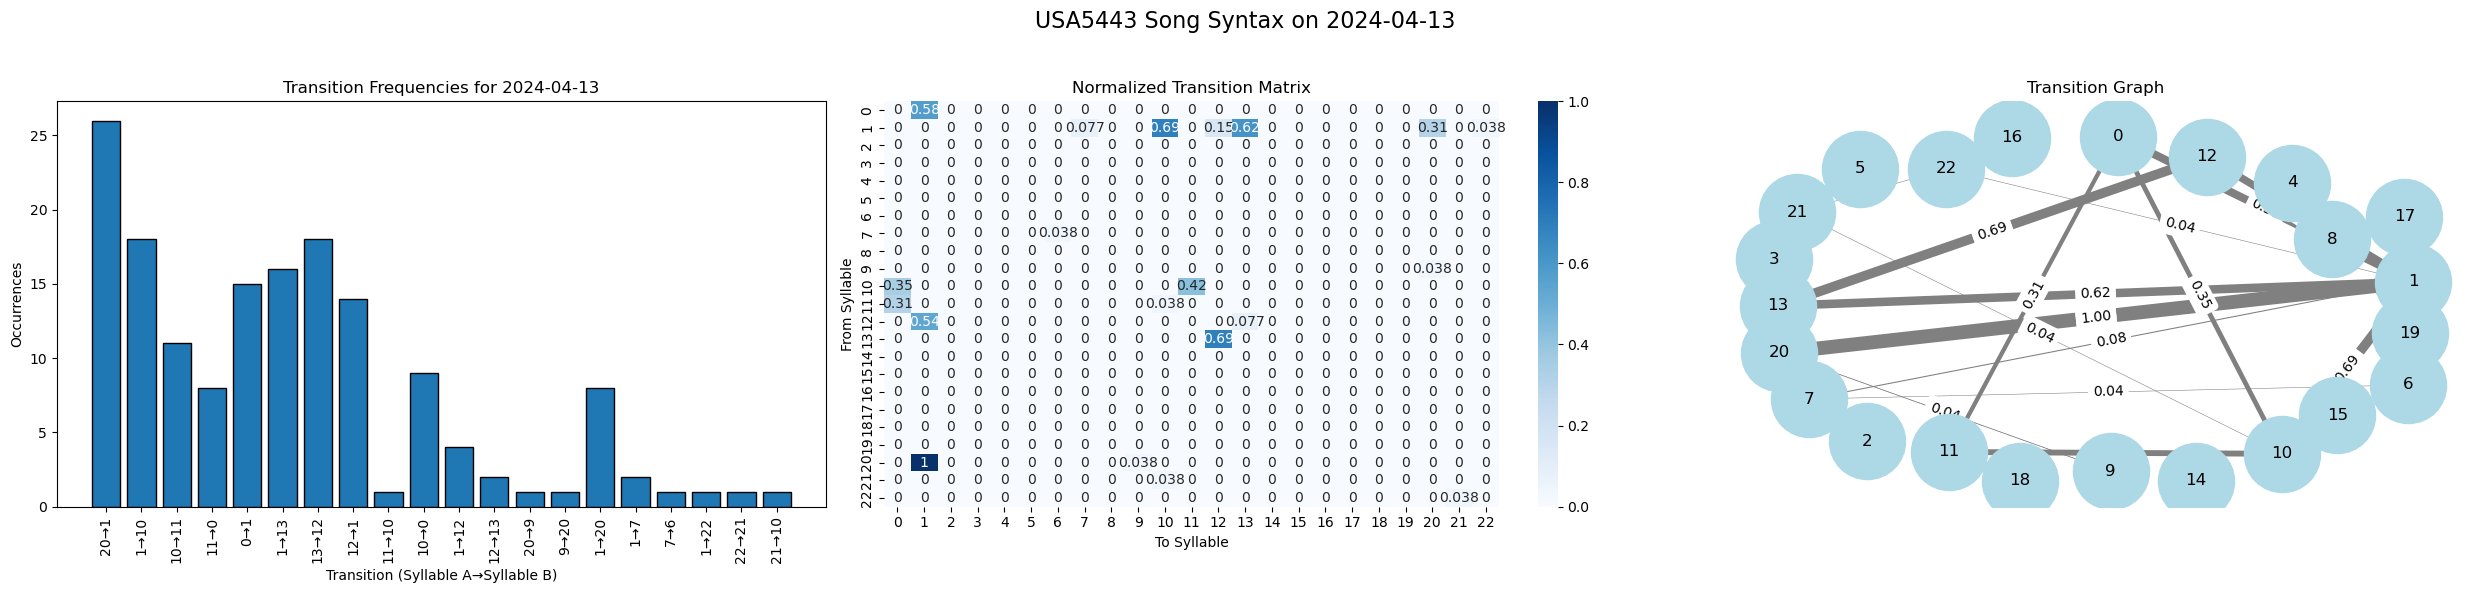

Analyzing transitions for: 2024-04-22
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-22_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-22_phrase_transitions.png


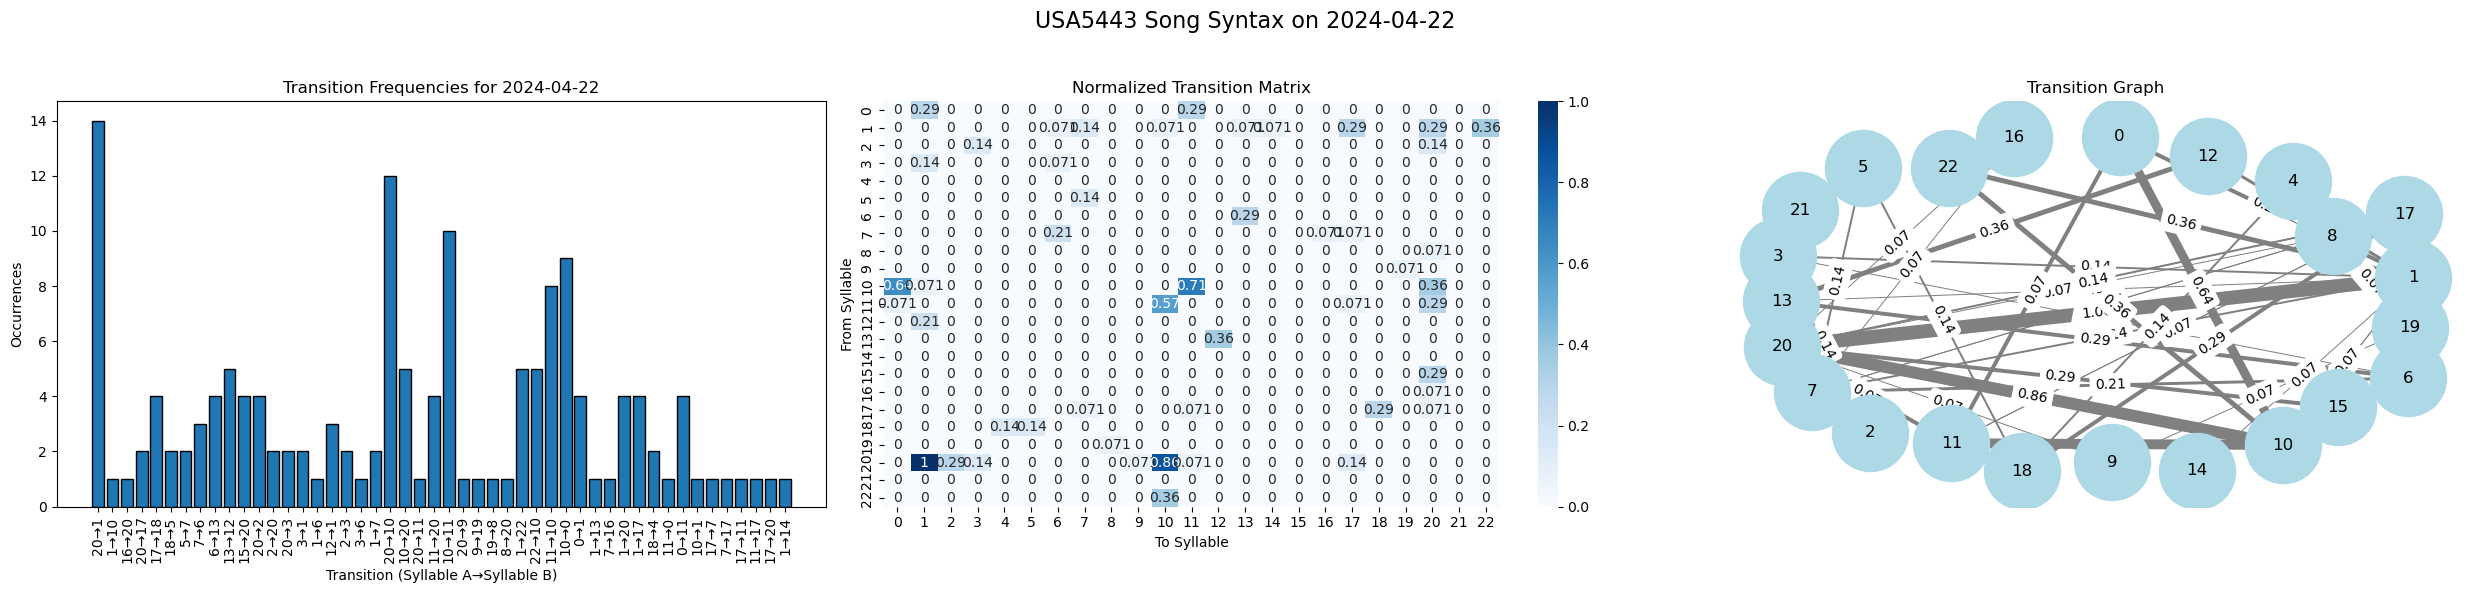

Analyzing transitions for: 2024-05-06
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-06_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-06_phrase_transitions.png


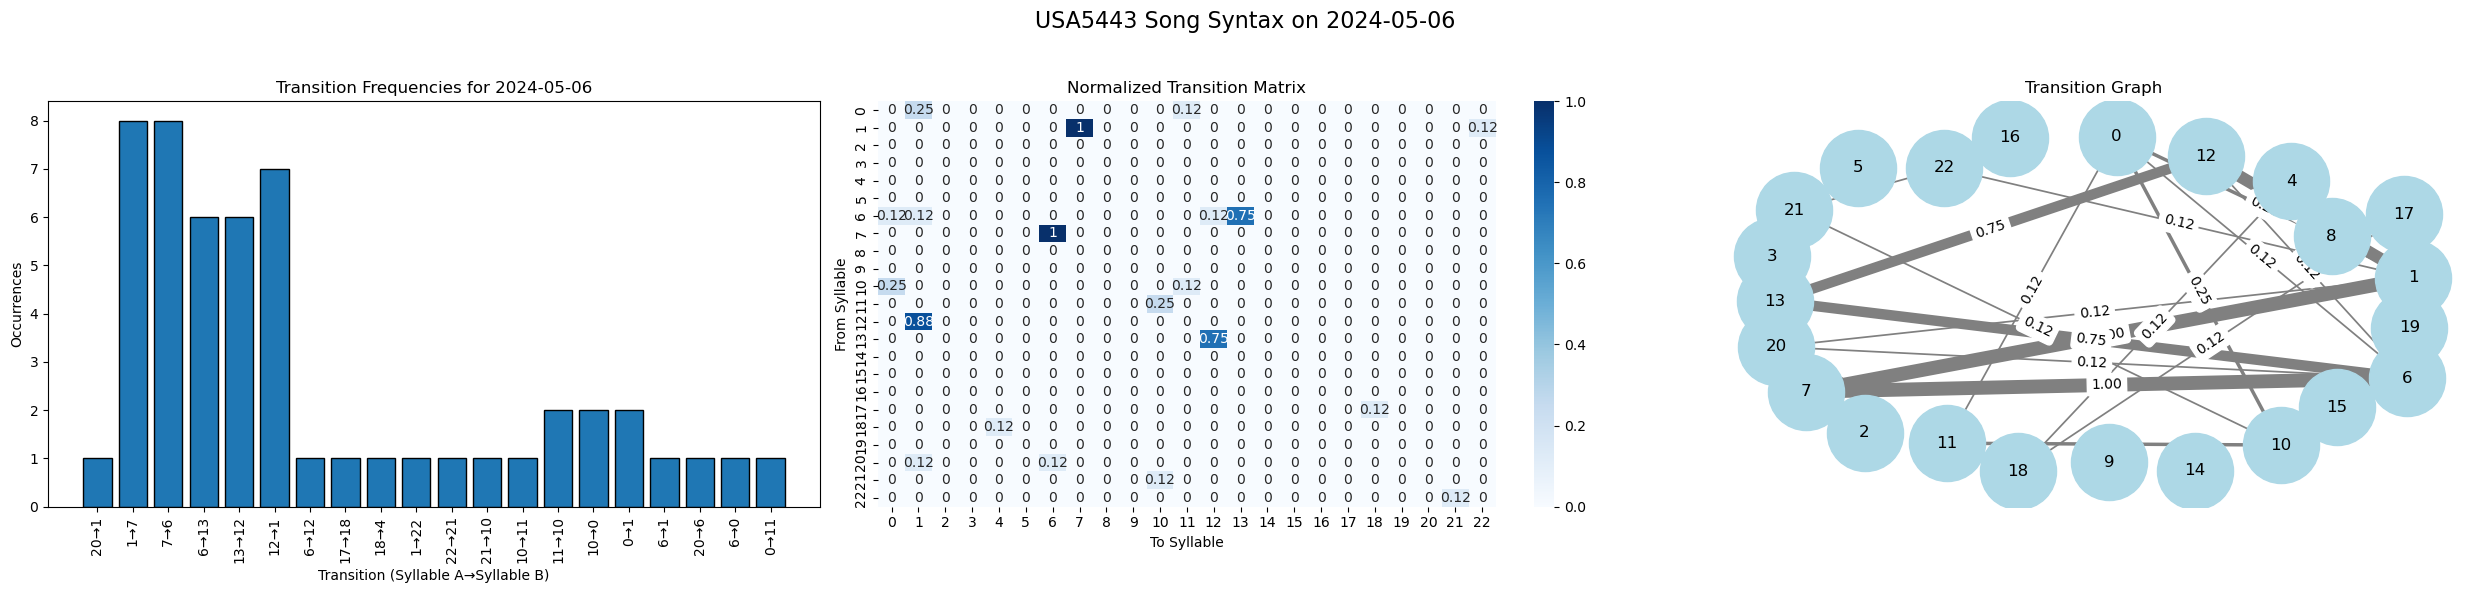

Analyzing transitions for: 2024-04-29
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-29_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-29_phrase_transitions.png


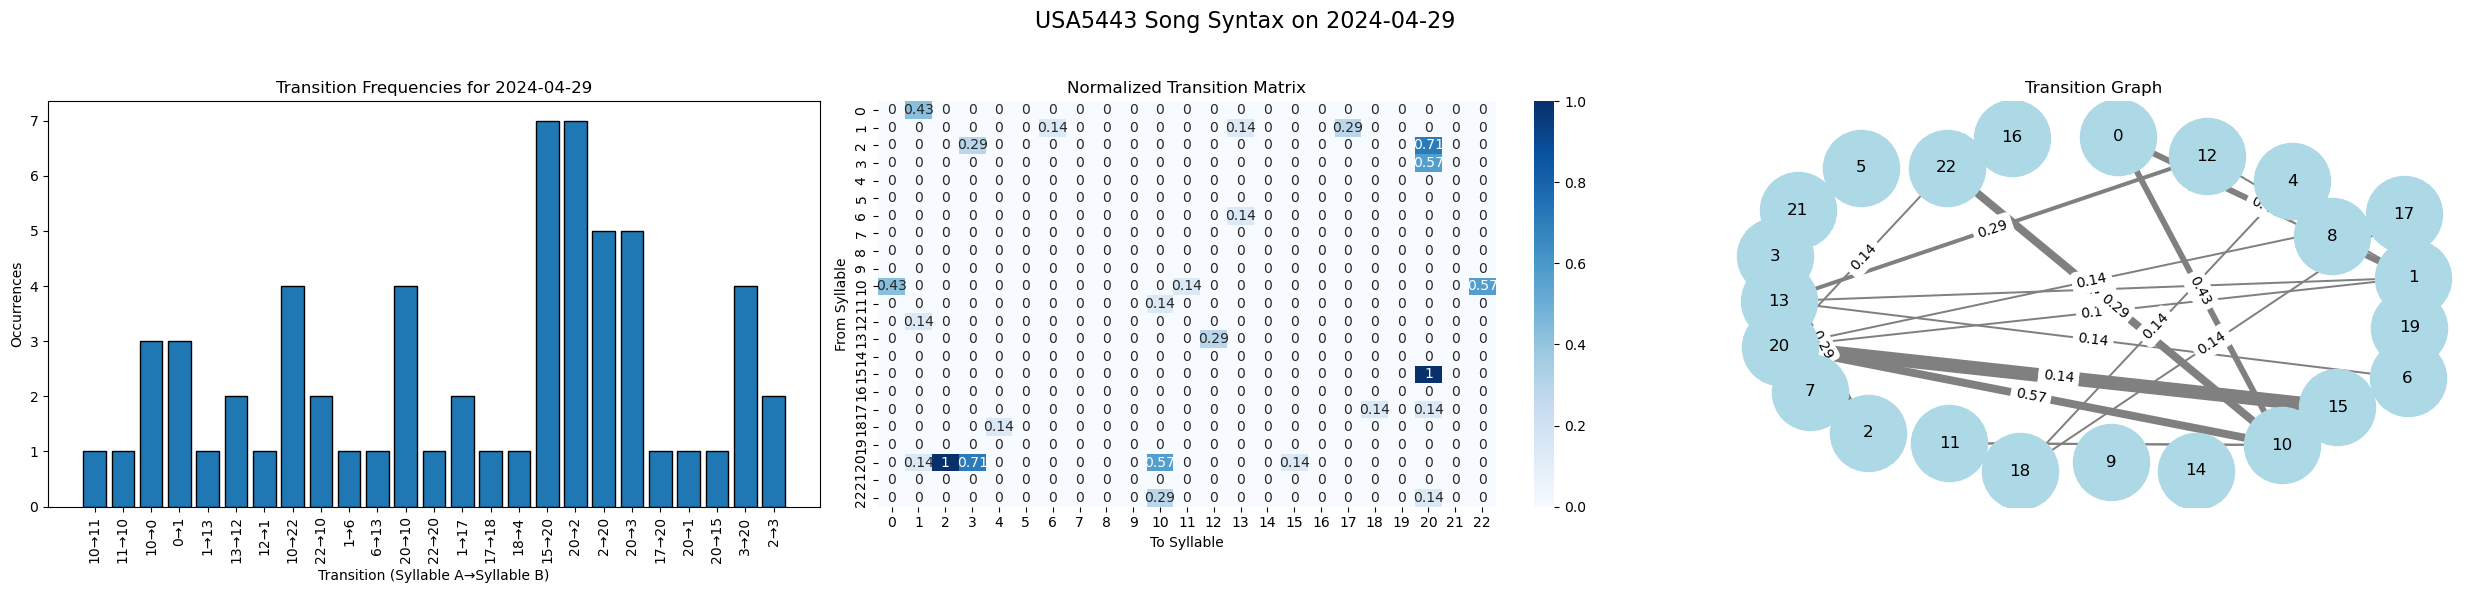

Analyzing transitions for: 2024-05-08
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-08_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-05-08_phrase_transitions.png


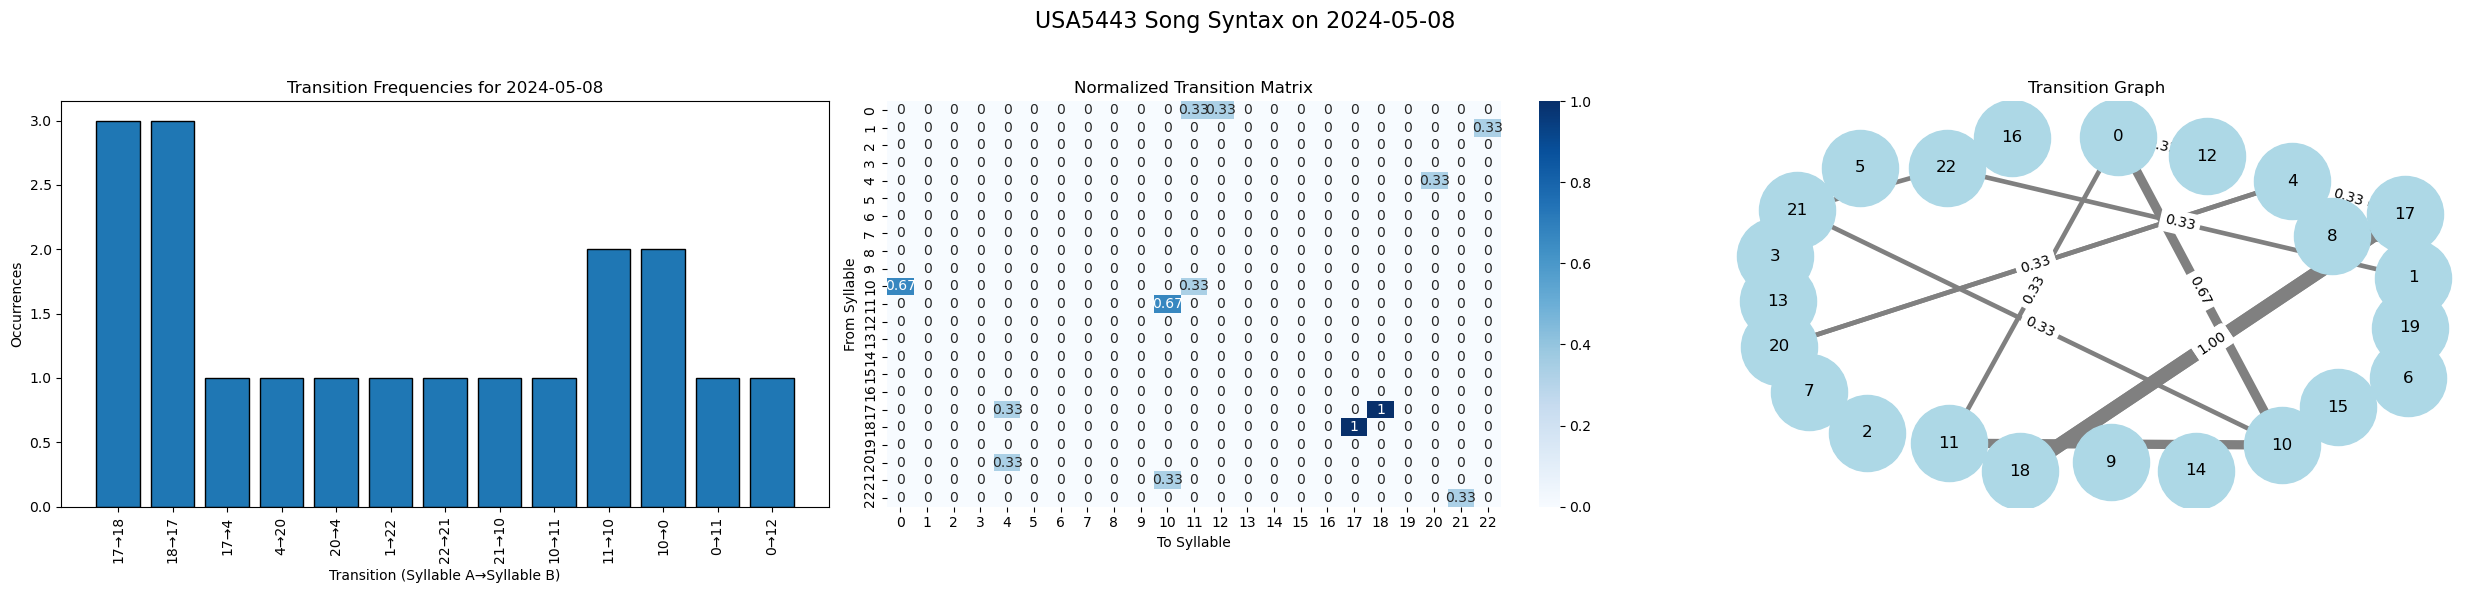

Analyzing transitions for: 2024-04-30
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-30_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-30_phrase_transitions.png


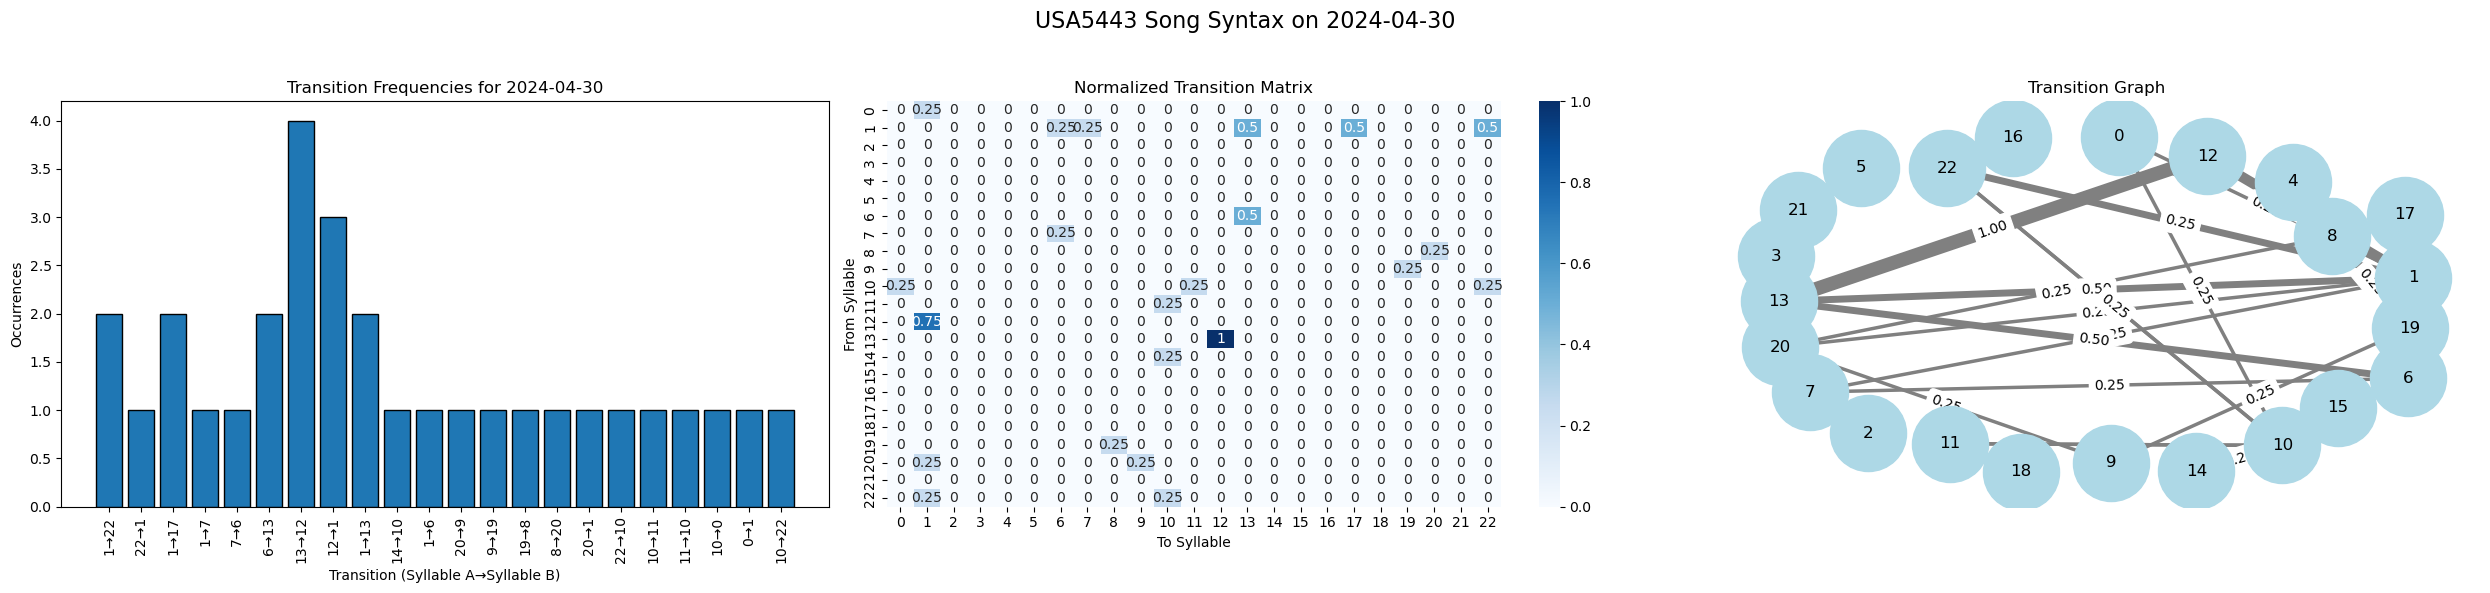

Analyzing transitions for: 2024-04-11
Saving figure to folder: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs
Saving figure as: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-11_phrase_transitions.png
File saved successfully at: /Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/USA5443_output_graphs/USA5443_2024-04-11_phrase_transitions.png


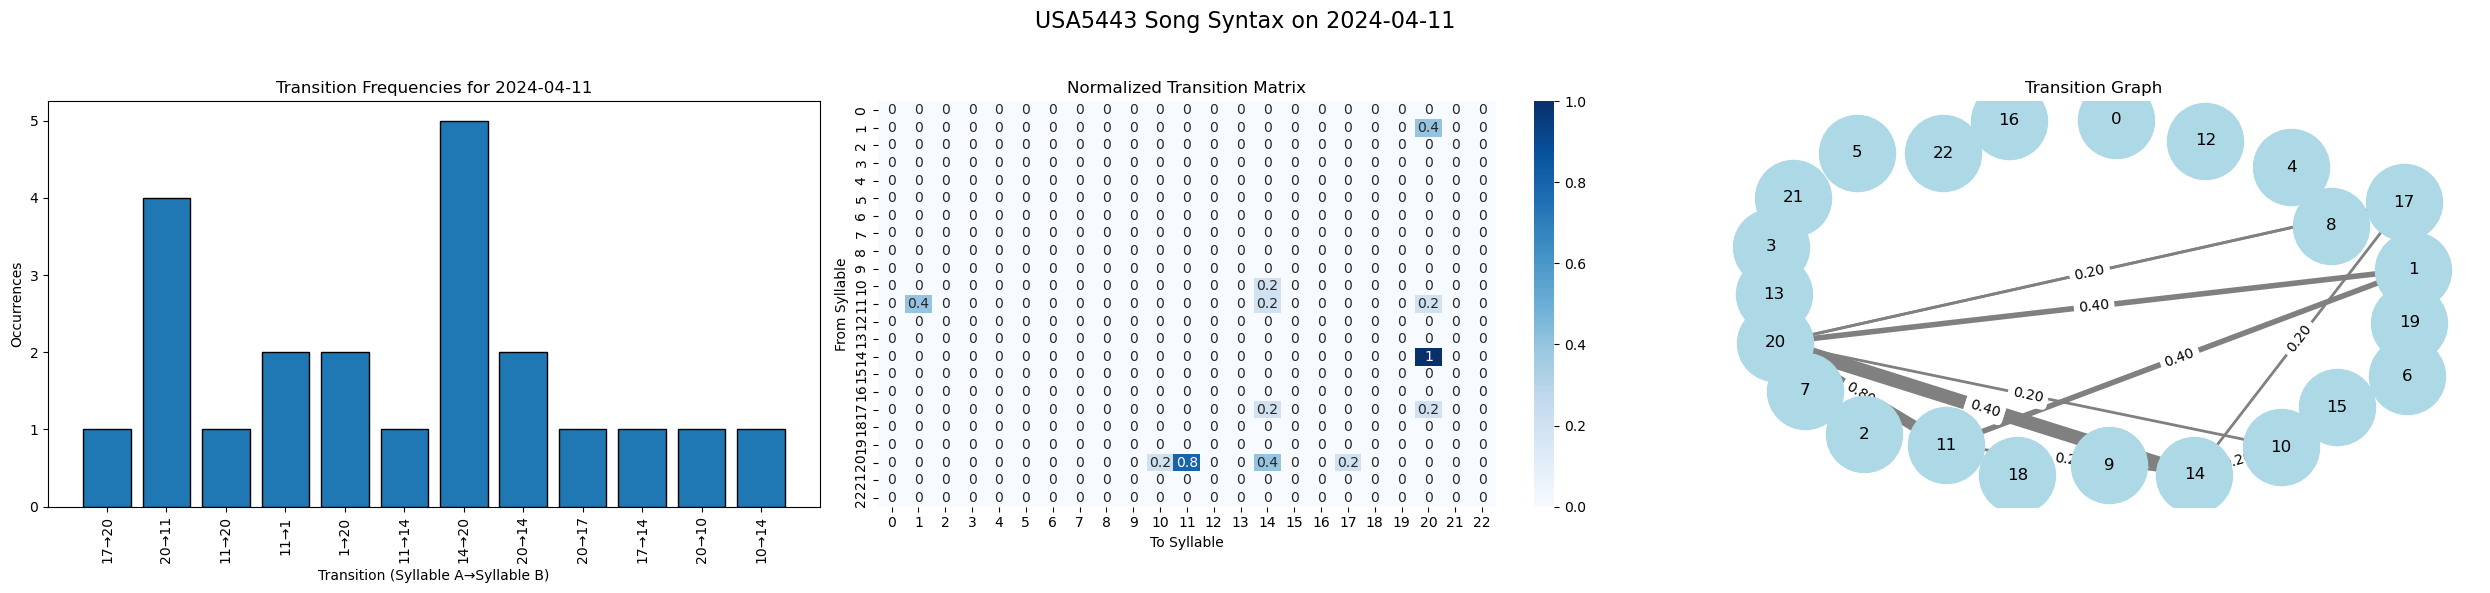

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

def analyze_transitions_for_each_day(annotation_data_frame):
    # Convert the 'date_time' column to datetime if not already done
    annotation_data_frame['date_time'] = pd.to_datetime(annotation_data_frame['date_time'])

    # Get all unique days in the dataset
    unique_days = annotation_data_frame['date_time'].dt.date.unique()

    # Get all unique syllables in the entire dataset to ensure a consistent layout across days
    all_transition_frequencies = {}
    for freq_dict in annotation_data_frame['transition_frequencies']:
        for transition, count in freq_dict.items():
            if transition in all_transition_frequencies:
                all_transition_frequencies[transition] += count
            else:
                all_transition_frequencies[transition] = count

    # Extract all unique syllable types
    syllable_types = sorted(set([t[0] for t in all_transition_frequencies.keys()] + [t[1] for t in all_transition_frequencies.keys()]))

    # Create a graph with all syllable types to generate a consistent layout
    G_for_layout = nx.DiGraph()
    G_for_layout.add_nodes_from(syllable_types)

    # Generate a consistent layout for the syllable labels
    consistent_layout = nx.spring_layout(G_for_layout, seed=42)

    for selected_day in unique_days:
        print(f"Analyzing transitions for: {selected_day}")

        # Create a figure with 3 subplots (histogram, transition matrix, and transition graph)
        fig, axes = plt.subplots(1, 3, figsize=(25, 6))
        fig.suptitle(f"{animal_ids[0]} Song Syntax on {selected_day}", fontsize=16)

        # Filter the dataset for the selected day
        day_data = annotation_data_frame[annotation_data_frame['date_time'].dt.date == selected_day]

        # Gather all transition frequencies for the selected day
        day_transition_frequencies = {}
        for freq_dict in day_data['transition_frequencies']:
            for transition, count in freq_dict.items():
                if transition in day_transition_frequencies:
                    day_transition_frequencies[transition] += count
                else:
                    day_transition_frequencies[transition] = count

        # Extract the transitions and their counts
        transition_list = list(day_transition_frequencies.keys())
        transition_counts = list(day_transition_frequencies.values())

        # Plot histogram in the first subplot
        plot_histogram_of_transitions(transition_list, transition_counts, selected_day, axes[0])

        # Generate normalized transition matrix and plot in the second subplot
        normalized_transition_matrix = generate_normalized_transition_matrix(transition_list, transition_counts, syllable_types, selected_day, axes[1])

        # Generate transition graph and plot in the third subplot
        plot_transition_graph(normalized_transition_matrix, syllable_types, selected_day, consistent_layout, axes[2])

        # Adjust layout and show
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
        # Check if save_figures_TF is True before saving
        if save_figures_TF:
            print(f"Saving figure to folder: {output_folder_path}")
            # Ensure the folder exists
            os.makedirs(output_folder_path, exist_ok=True)
            # Dynamically adjust the file name and folder path
            file_name = f'{output_folder_path}/{animal_ids[0]}_{selected_day}_phrase_transitions.png'
            print(f"Saving figure as: {file_name}")
            # Save the plot as a .png file in the specified folder
            plt.savefig(file_name, format='png', dpi=300)
            # Check if the file exists after saving
            if os.path.exists(file_name):
                print(f"File saved successfully at: {file_name}")
            else:
                print("Error: File was not saved.")
        else:
            print("save_figures_TF is False, skipping the save step.")

        plt.show()


def plot_histogram_of_transitions(transition_list, transition_counts, selected_day, ax):
    # Convert the transition tuples to readable labels (e.g., "1->2")
    transition_labels = [f"{t[0]}→{t[1]}" for t in transition_list]

    # Plot the histogram
    ax.bar(transition_labels, transition_counts, edgecolor='black')

    # Customize the x-ticks for better readability
    ax.set_xticks(np.arange(len(transition_labels)))
    ax.set_xticklabels(transition_labels, rotation=90)
    ax.set_title(f'Transition Frequencies for {selected_day}')
    ax.set_xlabel('Transition (Syllable A→Syllable B)')
    ax.set_ylabel('Occurrences')


def generate_normalized_transition_matrix(transition_list, transition_counts, syllable_types, selected_day, ax):
    num_syllables = len(syllable_types)
    transition_matrix = np.zeros((num_syllables, num_syllables))

    # Fill in the transition matrix with the counts
    for (from_syllable, to_syllable), count in zip(transition_list, transition_counts):
        i = syllable_types.index(from_syllable)
        j = syllable_types.index(to_syllable)
        transition_matrix[i, j] = count

    # Normalize the matrix by dividing by the maximum transition count
    max_count = np.max(transition_matrix)
    if max_count > 0:
        normalized_transition_matrix = transition_matrix / max_count
    else:
        normalized_transition_matrix = transition_matrix

    # Plot the normalized transition matrix as a heatmap
    sns.heatmap(normalized_transition_matrix, annot=True, cmap='Blues', xticklabels=syllable_types, yticklabels=syllable_types, ax=ax)
    ax.set_title(f'Normalized Transition Matrix')
    ax.set_xlabel('To Syllable')
    ax.set_ylabel('From Syllable')

    return normalized_transition_matrix


def plot_transition_graph(normalized_transition_matrix, syllable_types, selected_day, consistent_layout, ax):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes for each syllable type
    for syllable in syllable_types:
        G.add_node(syllable)

    # Add edges with weights corresponding to the transition probabilities
    for i, from_syllable in enumerate(syllable_types):
        for j, to_syllable in enumerate(syllable_types):
            weight = normalized_transition_matrix[i, j]
            if weight > 0:  # Only add edges where there is a transition
                G.add_edge(from_syllable, to_syllable, weight=weight)

    # Use the consistent layout for node positions
    pos = consistent_layout

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue', ax=ax)

    # Draw the edges with varying thickness based on the transition probabilities
    edges = G.edges(data=True)
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edgelist=[(u, v) for u, v, d in edges],
        width=[d['weight'] * 10 for u, v, d in edges],  # Scale the edge width by transition probabilities
        edge_color='gray'
    )

    # Draw the node labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', ax=ax)

    # Draw edge labels to show transition probabilities
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)

    ax.set_title(f'Transition Graph')
    ax.axis('off')  # Turn off the axis


# Example usage with your annotation_data_frame:
# Assuming 'annotation_data_frame' is the DataFrame you're working with
analyze_transitions_for_each_day(annotation_data_frame)

### Calculate the total transition entropy for the songs from each day. From Koparkar et al. 2024, transition entropy per branchpoint is defined as: 
$$ H_{a} = -\sum^c_{i=1}P(i)logP(i) $$

### Transition entropy is defined as:
$$ TE = -\sum^n_{b=1}H_{b}P(b)$$


Analyzing transitions for: 2023-10-28
Analyzing transitions for: 2023-10-21
Analyzing transitions for: 2023-10-24
Analyzing transitions for: 2023-11-08
Analyzing transitions for: 2023-10-25
Analyzing transitions for: 2023-10-17
Analyzing transitions for: 2024-02-02
Analyzing transitions for: 2023-10-15
Analyzing transitions for: 2023-10-20
Analyzing transitions for: 2023-10-31
Analyzing transitions for: 2024-01-11
Analyzing transitions for: 2023-10-19
Analyzing transitions for: 2023-10-18
Analyzing transitions for: 2024-01-13
Analyzing transitions for: 2024-01-07
Analyzing transitions for: 2023-11-06
Analyzing transitions for: 2024-01-29
Analyzing transitions for: 2024-01-14
Analyzing transitions for: 2024-01-06
Analyzing transitions for: 2024-01-20
Analyzing transitions for: 2023-10-16
Analyzing transitions for: 2023-11-04
Analyzing transitions for: 2023-11-01
Analyzing transitions for: 2023-11-05
Analyzing transitions for: 2023-10-26
Analyzing transitions for: 2024-01-22
Analyzing tr

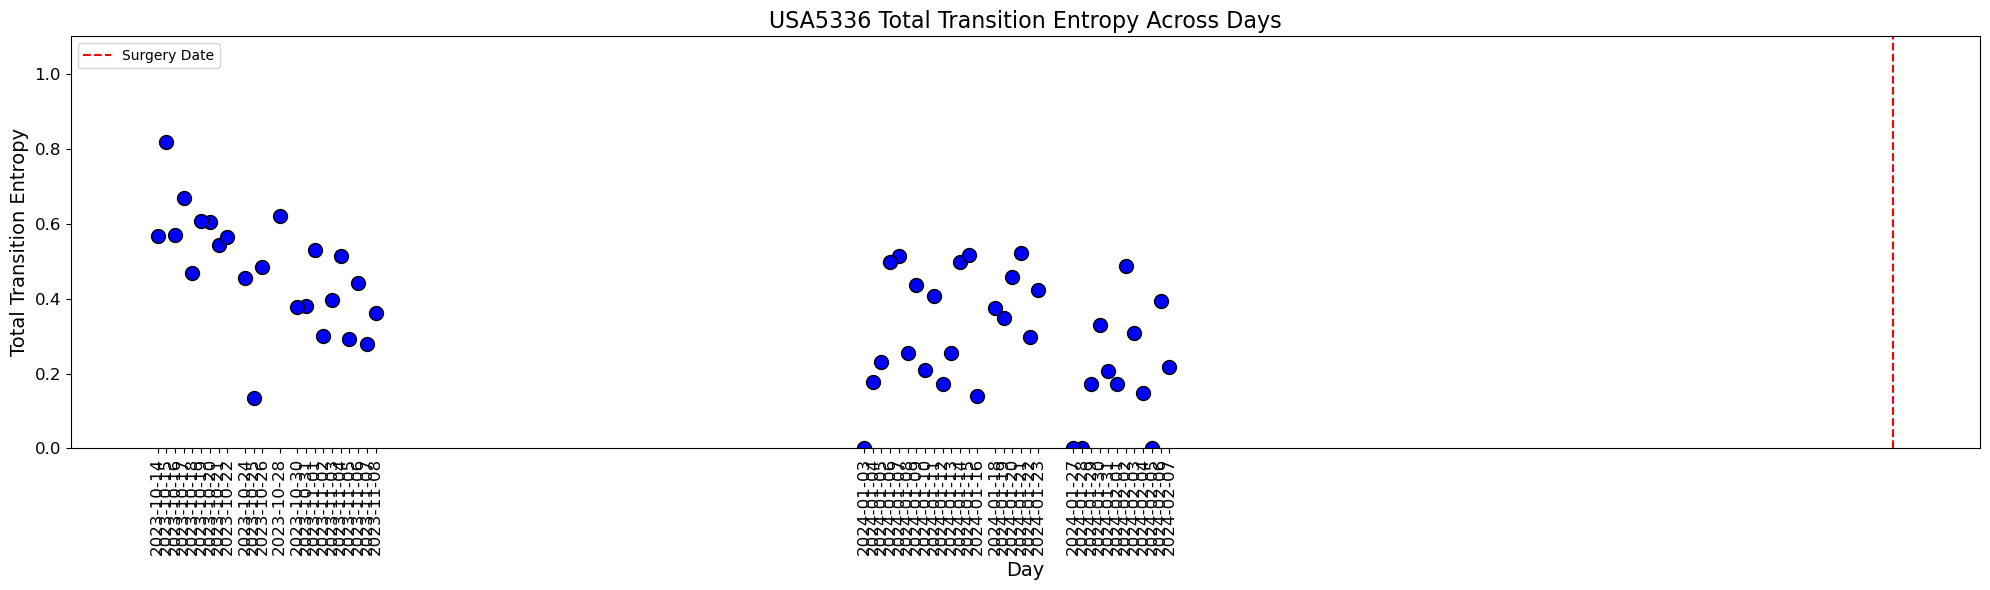

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

def analyze_transitions_for_each_day(annotation_data_frame, surgery_date):
    # Convert the 'date_time' column to datetime if not already done
    annotation_data_frame['date_time'] = pd.to_datetime(annotation_data_frame['date_time'])

    # Get all unique days in the dataset
    unique_days = annotation_data_frame['date_time'].dt.date.unique()

    # Get all unique syllables in the entire dataset to ensure a consistent layout across days
    all_transition_frequencies = {}
    for freq_dict in annotation_data_frame['transition_frequencies']:
        for transition, count in freq_dict.items():
            if transition in all_transition_frequencies:
                all_transition_frequencies[transition] += count
            else:
                all_transition_frequencies[transition] = count

    # Extract all unique syllable types
    syllable_types = sorted(set([t[0] for t in all_transition_frequencies.keys()] + [t[1] for t in all_transition_frequencies.keys()]))

    # Create a graph with all syllable types to generate a consistent layout
    G_for_layout = nx.DiGraph()
    G_for_layout.add_nodes_from(syllable_types)

    # Generate a consistent layout for the syllable labels
    consistent_layout = nx.spring_layout(G_for_layout, seed=42)

    # Store total entropy values for each day
    total_entropies_per_day = []

    for selected_day in unique_days:
        print(f"Analyzing transitions for: {selected_day}")

        # Filter the dataset for the selected day
        day_data = annotation_data_frame[annotation_data_frame['date_time'].dt.date == selected_day]

        # Gather all transition frequencies for the selected day
        day_transition_frequencies = {}
        for freq_dict in day_data['transition_frequencies']:
            for transition, count in freq_dict.items():
                if transition in day_transition_frequencies:
                    day_transition_frequencies[transition] += count
                else:
                    day_transition_frequencies[transition] = count

        # Extract the transitions and their counts
        transition_list = list(day_transition_frequencies.keys())
        transition_counts = list(day_transition_frequencies.values())

        # Generate normalized transition matrix
        normalized_transition_matrix = generate_normalized_transition_matrix(transition_list, transition_counts, syllable_types, selected_day)
        # Calculate transition entropies for the day
        transition_entropies = calculate_transition_entropy(normalized_transition_matrix, syllable_types)
        # Calculate total transition entropy for the day
        total_transition_entropy = calculate_total_transition_entropy(normalized_transition_matrix, syllable_types, transition_entropies)
        # Append the total entropy value to the list
        total_entropies_per_day.append((selected_day, total_transition_entropy))

    # Plot the total transition entropy across days
    plot_total_transition_entropy(total_entropies_per_day, surgery_date)

def calculate_transition_entropy(transition_matrix, syllable_types):
    transition_entropies = {}

    # Iterate through each syllable
    for i, from_syllable in enumerate(syllable_types):
        outgoing_probabilities = transition_matrix[i, :]

        # Filter out zero probabilities (no transitions)
        outgoing_probabilities = outgoing_probabilities[outgoing_probabilities > 0]

        # Calculate entropy for the current syllable using the formula
        entropy = -np.sum(outgoing_probabilities * np.log(outgoing_probabilities))
        transition_entropies[from_syllable] = entropy

    return transition_entropies

def calculate_total_transition_entropy(transition_matrix, syllable_types, transition_entropies):
    # Calculate the frequency of each syllable (row sums of the transition matrix)
    syllable_frequencies = np.sum(transition_matrix, axis=1)

    # Normalize the frequencies to get probabilities
    syllable_probabilities = syllable_frequencies / np.sum(syllable_frequencies)

    # Calculate total transition entropy (TE) using the formula
    total_entropy = 0
    for i, syllable in enumerate(syllable_types):
        H_b = transition_entropies[syllable]
        P_b = syllable_probabilities[i]
        total_entropy += H_b * P_b

    return total_entropy

def plot_total_transition_entropy(entropies_per_day, surgery_date):
    # Unpack days and entropy values
    days, entropies = zip(*entropies_per_day)

    # Create a scatter plot of entropy values across days
    plt.figure(figsize=(20, 6))
    plt.scatter(days, entropies, color='b', s=100, edgecolor='black')  # Removed label for total transition entropy
    
    # Plot a vertical dashed red line at the surgery date
    plt.axvline(x=surgery_date, color='r', linestyle='--', label='Surgery Date')
    
    # Set x-ticks to include every day of recording
    plt.xticks(ticks=days, labels=[day.strftime('%Y-%m-%d') for day in days], rotation=90)

    # Formatting the plot without grid lines and with larger font sizes
    plt.title(f'{animal_ids[0]} Total Transition Entropy Across Days', fontsize=16)
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('Total Transition Entropy', fontsize=14)
    
    # Set the y-axis limits to greater than 1, so I can see if there are calculation errors (e.g. TE > 1)
    plt.ylim(0, 1.1) 
    
    # Increase font size for x-tick and y-tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend()  # Add legend, but only for surgery date
    plt.tight_layout()
    # Check if save_figures_TF is True before saving
    if save_figures_TF:
        print(f"Saving figure to folder: {output_folder_path}")

        # Ensure the folder exists
        os.makedirs(output_folder_path, exist_ok=True)

        # Dynamically adjust the file name and folder path
        file_name = f'{output_folder_path}/{animal_ids[0]}_total_transition_entropies_across_days.png'
        print(f"Saving figure as: {file_name}")

        # Save the plot as a .png file in the specified folder
        plt.savefig(file_name, format='png', dpi=300)

        # Check if the file exists after saving
        if os.path.exists(file_name):
            print(f"File saved successfully at: {file_name}")
        else:
            print("Error: File was not saved.")
    else:
        print("save_figures_TF is False, skipping the save step.")

    plt.show()

def generate_normalized_transition_matrix(transition_list, transition_counts, syllable_types, selected_day):
    num_syllables = len(syllable_types)
    transition_matrix = np.zeros((num_syllables, num_syllables))

    # Fill in the transition matrix with the counts
    for (from_syllable, to_syllable), count in zip(transition_list, transition_counts):
        i = syllable_types.index(from_syllable)
        j = syllable_types.index(to_syllable)
        transition_matrix[i, j] = count

    # Normalize each row so that the sum of transitions from each syllable equals 1
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    normalized_transition_matrix = transition_matrix / row_sums

    return normalized_transition_matrix


# Example usage with your annotation_data_frame:
# Assuming 'annotation_data_frame' is the DataFrame you're working with

#next step: make sure this takes in the surgery_date from teh first cell
#surgery_date = pd.to_datetime('2024-06-28').date()  # Set your surgery date
analyze_transitions_for_each_day(annotation_data_frame, surgery_date)


# Updated with fixes from George!!!

In [ ]:
mport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
def analyze_transitions_for_each_day(annotation_data_frame, surgery_date):
    # Convert the 'date_time' column to datetime if not already done
    annotation_data_frame['date_time'] = pd.to_datetime(annotation_data_frame['date_time'])
    # Get all unique days in the dataset
    unique_days = annotation_data_frame['date_time'].dt.date.unique()
    # Get all unique syllables in the entire dataset to ensure a consistent layout across days
    all_transition_frequencies = {}
    for freq_dict in annotation_data_frame['transition_frequencies']:
        for transition, count in freq_dict.items():
            if transition in all_transition_frequencies:
                all_transition_frequencies[transition] += count
            else:
                all_transition_frequencies[transition] = count
    # Extract all unique syllable types
    syllable_types = sorted(set([t[0] for t in all_transition_frequencies.keys()] + [t[1] for t in all_transition_frequencies.keys()]))
    # Create a graph with all syllable types to generate a consistent layout
    G_for_layout = nx.DiGraph()
    G_for_layout.add_nodes_from(syllable_types)
    # Generate a consistent layout for the syllable labels
    consistent_layout = nx.spring_layout(G_for_layout, seed=42)
    # Store total entropy values for each day
    total_entropies_per_day = []
    for selected_day in unique_days:
        # Filter the dataset for the selected day
        day_data = annotation_data_frame[annotation_data_frame['date_time'].dt.date == selected_day]
        # Gather all transition frequencies for the selected day
        day_transition_frequencies = {}
        for freq_dict in day_data['transition_frequencies']:
            for transition, count in freq_dict.items():
                if transition in day_transition_frequencies:
                    day_transition_frequencies[transition] += count
                else:
                    day_transition_frequencies[transition] = count
        # Extract the transitions and their counts
        transition_list = list(day_transition_frequencies.keys())
        transition_counts = list(day_transition_frequencies.values())
        # Generate normalized transition matrix and counts matrix
        normalized_transition_matrix, transition_counts_matrix = generate_normalized_transition_matrix(
            transition_list, transition_counts, syllable_types, selected_day
        )
        # Calculate transition entropies for the day
        transition_entropies = calculate_transition_entropy(normalized_transition_matrix, syllable_types)
        # Calculate total transition entropy for the day
        total_transition_entropy = calculate_total_transition_entropy(
            transition_counts_matrix, syllable_types, transition_entropies
        )
        # Append the total entropy value to the list
        total_entropies_per_day.append((selected_day, total_transition_entropy))
    # Plot the total transition entropy across days
    plot_total_transition_entropy(total_entropies_per_day, surgery_date)
def calculate_transition_entropy(transition_matrix, syllable_types):
    transition_entropies = {}
    # Iterate through each syllable
    for i, from_syllable in enumerate(syllable_types):
        outgoing_probabilities = transition_matrix[i, :]
        # Filter out zero probabilities (no transitions)
        outgoing_probabilities = outgoing_probabilities[outgoing_probabilities > 0]
        # Calculate entropy for the current syllable using the formula
        if len(outgoing_probabilities) > 0:
            entropy = -np.sum(outgoing_probabilities * np.log2(outgoing_probabilities))
        else:
            entropy = 0  # No outgoing transitions, entropy is zero
        transition_entropies[from_syllable] = entropy
    return transition_entropies
def calculate_total_transition_entropy(transition_counts_matrix, syllable_types, transition_entropies):
    # Calculate the frequency of each syllable (row sums of the transition counts matrix)
    syllable_frequencies = np.sum(transition_counts_matrix, axis=1)
    # Normalize the frequencies to get probabilities
    total_transitions = np.sum(syllable_frequencies)
    if total_transitions > 0:
        syllable_probabilities = syllable_frequencies / total_transitions
    else:
        syllable_probabilities = np.zeros_like(syllable_frequencies)
    # Calculate total transition entropy (TE) using the formula
    total_entropy = 0
    for i, syllable in enumerate(syllable_types):
        H_b = transition_entropies[syllable]
        P_b = syllable_probabilities[i]
        total_entropy += H_b * P_b
    return total_entropy
def plot_total_transition_entropy(entropies_per_day, surgery_date):
    # Unpack days and entropy values
    days, entropies = zip(*entropies_per_day)
    # Create a scatter plot of entropy values across days
    plt.figure(figsize=(20, 6))
    plt.scatter(days, entropies, color='b', s=100, edgecolor='black')
    # Plot a vertical dashed red line at the surgery date
    plt.axvline(x=surgery_date, color='r', linestyle='--', label='Surgery Date')
    # Set x-ticks to include every day of recording
    plt.xticks(ticks=days, labels=[day.strftime('%Y-%m-%d') for day in days], rotation=90)
    # Formatting the plot without grid lines and with larger font sizes
    plt.title(f'Total Transition Entropy Across Days', fontsize=16)
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('Total Transition Entropy', fontsize=14)
    # Increase font size for x-tick and y-tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()  # Add legend, but only for surgery date
    plt.tight_layout()
    plt.show()
def generate_normalized_transition_matrix(transition_list, transition_counts, syllable_types, selected_day):
    num_syllables = len(syllable_types)
    transition_counts_matrix = np.zeros((num_syllables, num_syllables))
    # Fill in the transition counts matrix with the counts
    for (from_syllable, to_syllable), count in zip(transition_list, transition_counts):
        i = syllable_types.index(from_syllable)
        j = syllable_types.index(to_syllable)
        transition_counts_matrix[i, j] = count
    # Normalize each row so that the sum of transitions from each syllable equals 1
    row_sums = transition_counts_matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    normalized_transition_matrix = transition_counts_matrix / row_sums
    return normalized_transition_matrix, transition_counts_matrix
# Example usage with your annotation_data_frame:
# Assuming 'annotation_data_frame' is the DataFrame you're working with
# and 'surgery_date' is provided as a datetime.date object
# Example usage:
# surgery_date = pd.to_datetime('2024-06-28').date()  # Set your surgery date
# animal_id = 'YourAnimalID'
# analyze_transitions_for_each_day(annotation_data_frame, surgery_date)